# Cart and Pole System Identification

Two architectures were investigated in system identification step: RNN and LSTM. The detail of the training can be found in the file "System identification.ipynb". The models were choosen because this was a time-series modeling and repeated computation was needed on variable input size. 

The input was the controller actions: push car left or right.

The outputs were the four states: pole angle and velocity, cart position and velocity.

The models were:
- One directional RNN (Input=1,Output=4, Hidden States = 8, layers = 3)
- One directional LSTM (Input=1,Output=4, Hidden States = 8, layers = 3)


Methodology:
1. 300 training example and 50 testing example were generate using OpenAI GYM. Each example has a sequence length of 20 time step. Meaning the cart was pushed in random directions for 20 timesteps and this was repeated 350 times at different initialisation state.
2. All four states were normalized to have mean of 0 and standard diviation of 1 since the magnetude of velocity can be quite different from position.
3. The models's first layer's hidden state was then initialized with the system's initial condition.
4. The input is then fed into the model to obtain predicted output.
5. Define loss function as the Mean Squared Error (MSE) across the four predicted state.
6. Optimize model parameters.

It was found the LSTM model predicted the dynamics munch better than the RNN model: 
- RNN model testing MSE: 0.018
- LSTM model testing MS: 0.001

Figures at the end of the notebook can be found plotting the predicted and actual states of the system using the LSTM model. The prediction has very minimal error with angle deviation up to 30 degrees. In this range of angles, the dinamics is highly non-linear, demonstrating the ability of LSTM models to model non-linear dynamical systems.

In [32]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [120]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
env = gym.make('CartPole-v0')

## Generate data

In [85]:
def random_act(prob=0.5):
    if np.random.uniform() < prob:
        act=float(1)
    else:
        act=float(0)
    return act

In [86]:
batch_size = 300
test_size = 50
sequence_length = 20

data = []
actions = []
j=0

while not j >= batch_size+test_size :
    
    observation = env.reset()
    done = False
    
    sequence=[observation]
    acts=[0.0]

    for i in range(sequence_length):
    
        act = random_act()
        acts.append(act)
        observation, reward, done, _ = env.step(int(act))
        sequence.append(observation)
        
    if acts not in actions:
        data.append(sequence)
        actions.append(acts)
        j=j+1

/home/lilly/anaconda3/envs/MIE1516F/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Normalize Data

In [87]:
class Normalizer():
    def __init__(self, data_n):
        self.mean = data_n.view(-1,data_n.size(2)).mean(dim=0).unsqueeze(0).unsqueeze(0).cuda()
        self.std = data_n.view(-1,data_n.size(2)).std(dim=0).unsqueeze(0).unsqueeze(0).cuda()
    def normalize(self, data_n):
        return (data_n-self.mean)/self.std
    
    def de_normalize(self,data_n):
        return data_n*self.std+self.mean

In [88]:
data_t=torch.FloatTensor(data).cuda()

In [89]:
normalizer=Normalizer(data_t)
data_n = normalizer.normalize(data_t)

x_train=Variable(torch.FloatTensor(actions)[test_size:,1:].unsqueeze(2).cuda())
y_train=Variable(data_n[test_size:,1:,:])

x_test=Variable(torch.FloatTensor(actions)[0:test_size,1:].unsqueeze(2).cuda())
y_test=Variable(data_n[0:test_size,1:,:])

In [90]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([300, 20, 1])
torch.Size([300, 20, 4])
torch.Size([50, 20, 1])
torch.Size([50, 20, 4])


## Define Plant Models

In [192]:
class plant_RNN(nn.Module):
    def __init__(self, output_size = 4, input_size = 1, hidden_size = 8, num_layers = 3):
        super(plant_RNN,self).__init__()
        
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn=nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size,batch_first=True,num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x, hidden):
        
        out, hidden = self.rnn(x,hidden)
        out = self.fc(out)
        return hidden, out
    
    def init_hidden(self, init_state):
        
        zeros=torch.zeros([self.num_layers-1,init_state.size(0), self.hidden_size], dtype=torch.float32).cuda()
        mid=torch.cat((init_state,init_state),dim=1).unsqueeze(0)
        
        h_0=Variable(torch.cat((mid,zeros),dim=0))
        return h_0

In [193]:
class plant_LSTM(nn.Module):
    def __init__(self, output_size = 4, input_size = 1, hidden_size = 8, num_layers = 3):
        super(plant_LSTM,self).__init__()
        
        self.output_size = output_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm=nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size,batch_first=True,num_layers=self.num_layers)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden):
        
        out, hidden = self.lstm(x,hidden)
        out = self.fc(out)

        return hidden, out
    
    def init_hidden(self, init_state):
        
        zeros=torch.zeros([self.num_layers-1,init_state.size(0), self.hidden_size], dtype=torch.float32).cuda()
        mid=torch.cat((init_state,init_state),dim=1).unsqueeze(0)
        
        h_0=Variable(torch.cat((mid,zeros),dim=0))
        c_0=torch.zeros([self.num_layers, init_state.size(0),self.hidden_size], dtype=torch.float32).cuda()
        
        return (h_0,c_0)
    

## Train RNN

In [194]:
def plot_loss(count,loss_graph,scale=3):
    xlabel='Number of Epoch'
    ylabel='Mean Squared Root Error'
    
    width = scale*3.487
    height = width / 1.618

    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    ax.plot(count, loss_graph,'-')

In [195]:
def adjust_learning_rate(optimizer, epoch,init_lr):
    lr = init_lr 
    if epoch >= 10000:
        lr = init_lr * 0.5
    if epoch >= 15000:
        lr = init_lr * 0.5 * 0.5
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [196]:
def train_plant(model, x_train, y_train, init_lr=0.0005):

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    count=[]
    loss_graph=[]

    for epoch in range(20000):

        model.zero_grad()
        loss=0

        hidden=model.init_hidden(data_n[test_size:,0,:])
        hidden,output=model(x_train,hidden)
        loss=criterion(output,y_train)

        print("epoch: %d, loss: %1.5f" % (epoch + 1, loss.data))
        count.append(epoch)
        loss_graph.append(loss.data)

        loss.backward()

        adjust_learning_rate(optimizer,epoch,init_lr)
        optimizer.step()
    
    return count,loss_graph

plant_RNN(
  (rnn): RNN(1, 8, num_layers=3, batch_first=True)
  (fc): Linear(in_features=8, out_features=4, bias=True)
)
epoch: 1, loss: 1.13842
epoch: 2, loss: 1.13580
epoch: 3, loss: 1.13323
epoch: 4, loss: 1.13071
epoch: 5, loss: 1.12823
epoch: 6, loss: 1.12579
epoch: 7, loss: 1.12340
epoch: 8, loss: 1.12105
epoch: 9, loss: 1.11873
epoch: 10, loss: 1.11646
epoch: 11, loss: 1.11423
epoch: 12, loss: 1.11203
epoch: 13, loss: 1.10987
epoch: 14, loss: 1.10775
epoch: 15, loss: 1.10567
epoch: 16, loss: 1.10362
epoch: 17, loss: 1.10161
epoch: 18, loss: 1.09963
epoch: 19, loss: 1.09768
epoch: 20, loss: 1.09577
epoch: 21, loss: 1.09389
epoch: 22, loss: 1.09205
epoch: 23, loss: 1.09024
epoch: 24, loss: 1.08846
epoch: 25, loss: 1.08672
epoch: 26, loss: 1.08501
epoch: 27, loss: 1.08333
epoch: 28, loss: 1.08168
epoch: 29, loss: 1.08007
epoch: 30, loss: 1.07849
epoch: 31, loss: 1.07694
epoch: 32, loss: 1.07542
epoch: 33, loss: 1.07394
epoch: 34, loss: 1.07250
epoch: 35, loss: 1.07108
epoch: 36, lo

epoch: 343, loss: 0.27894
epoch: 344, loss: 0.27811
epoch: 345, loss: 0.27728
epoch: 346, loss: 0.27645
epoch: 347, loss: 0.27564
epoch: 348, loss: 0.27482
epoch: 349, loss: 0.27401
epoch: 350, loss: 0.27320
epoch: 351, loss: 0.27239
epoch: 352, loss: 0.27159
epoch: 353, loss: 0.27079
epoch: 354, loss: 0.27000
epoch: 355, loss: 0.26920
epoch: 356, loss: 0.26841
epoch: 357, loss: 0.26762
epoch: 358, loss: 0.26683
epoch: 359, loss: 0.26604
epoch: 360, loss: 0.26526
epoch: 361, loss: 0.26448
epoch: 362, loss: 0.26371
epoch: 363, loss: 0.26293
epoch: 364, loss: 0.26216
epoch: 365, loss: 0.26139
epoch: 366, loss: 0.26063
epoch: 367, loss: 0.25987
epoch: 368, loss: 0.25911
epoch: 369, loss: 0.25837
epoch: 370, loss: 0.25763
epoch: 371, loss: 0.25691
epoch: 372, loss: 0.25618
epoch: 373, loss: 0.25542
epoch: 374, loss: 0.25463
epoch: 375, loss: 0.25382
epoch: 376, loss: 0.25305
epoch: 377, loss: 0.25233
epoch: 378, loss: 0.25162
epoch: 379, loss: 0.25089
epoch: 380, loss: 0.25013
epoch: 381, 

epoch: 691, loss: 0.12603
epoch: 692, loss: 0.12564
epoch: 693, loss: 0.12523
epoch: 694, loss: 0.12479
epoch: 695, loss: 0.12432
epoch: 696, loss: 0.12386
epoch: 697, loss: 0.12341
epoch: 698, loss: 0.12298
epoch: 699, loss: 0.12254
epoch: 700, loss: 0.12209
epoch: 701, loss: 0.12162
epoch: 702, loss: 0.12114
epoch: 703, loss: 0.12067
epoch: 704, loss: 0.12020
epoch: 705, loss: 0.11973
epoch: 706, loss: 0.11926
epoch: 707, loss: 0.11879
epoch: 708, loss: 0.11831
epoch: 709, loss: 0.11782
epoch: 710, loss: 0.11733
epoch: 711, loss: 0.11684
epoch: 712, loss: 0.11635
epoch: 713, loss: 0.11586
epoch: 714, loss: 0.11537
epoch: 715, loss: 0.11489
epoch: 716, loss: 0.11440
epoch: 717, loss: 0.11392
epoch: 718, loss: 0.11343
epoch: 719, loss: 0.11295
epoch: 720, loss: 0.11247
epoch: 721, loss: 0.11199
epoch: 722, loss: 0.11152
epoch: 723, loss: 0.11106
epoch: 724, loss: 0.11060
epoch: 725, loss: 0.11016
epoch: 726, loss: 0.10973
epoch: 727, loss: 0.10933
epoch: 728, loss: 0.10897
epoch: 729, 

epoch: 1013, loss: 0.06104
epoch: 1014, loss: 0.06095
epoch: 1015, loss: 0.06086
epoch: 1016, loss: 0.06079
epoch: 1017, loss: 0.06073
epoch: 1018, loss: 0.06068
epoch: 1019, loss: 0.06061
epoch: 1020, loss: 0.06054
epoch: 1021, loss: 0.06046
epoch: 1022, loss: 0.06039
epoch: 1023, loss: 0.06032
epoch: 1024, loss: 0.06026
epoch: 1025, loss: 0.06020
epoch: 1026, loss: 0.06013
epoch: 1027, loss: 0.06007
epoch: 1028, loss: 0.05999
epoch: 1029, loss: 0.05992
epoch: 1030, loss: 0.05986
epoch: 1031, loss: 0.05979
epoch: 1032, loss: 0.05973
epoch: 1033, loss: 0.05967
epoch: 1034, loss: 0.05960
epoch: 1035, loss: 0.05954
epoch: 1036, loss: 0.05947
epoch: 1037, loss: 0.05940
epoch: 1038, loss: 0.05934
epoch: 1039, loss: 0.05927
epoch: 1040, loss: 0.05921
epoch: 1041, loss: 0.05915
epoch: 1042, loss: 0.05909
epoch: 1043, loss: 0.05902
epoch: 1044, loss: 0.05896
epoch: 1045, loss: 0.05889
epoch: 1046, loss: 0.05883
epoch: 1047, loss: 0.05877
epoch: 1048, loss: 0.05870
epoch: 1049, loss: 0.05864
e

epoch: 1344, loss: 0.04564
epoch: 1345, loss: 0.04561
epoch: 1346, loss: 0.04558
epoch: 1347, loss: 0.04554
epoch: 1348, loss: 0.04551
epoch: 1349, loss: 0.04548
epoch: 1350, loss: 0.04545
epoch: 1351, loss: 0.04542
epoch: 1352, loss: 0.04539
epoch: 1353, loss: 0.04536
epoch: 1354, loss: 0.04533
epoch: 1355, loss: 0.04530
epoch: 1356, loss: 0.04527
epoch: 1357, loss: 0.04523
epoch: 1358, loss: 0.04520
epoch: 1359, loss: 0.04517
epoch: 1360, loss: 0.04514
epoch: 1361, loss: 0.04511
epoch: 1362, loss: 0.04508
epoch: 1363, loss: 0.04505
epoch: 1364, loss: 0.04502
epoch: 1365, loss: 0.04499
epoch: 1366, loss: 0.04496
epoch: 1367, loss: 0.04493
epoch: 1368, loss: 0.04490
epoch: 1369, loss: 0.04487
epoch: 1370, loss: 0.04484
epoch: 1371, loss: 0.04481
epoch: 1372, loss: 0.04478
epoch: 1373, loss: 0.04475
epoch: 1374, loss: 0.04472
epoch: 1375, loss: 0.04469
epoch: 1376, loss: 0.04466
epoch: 1377, loss: 0.04463
epoch: 1378, loss: 0.04460
epoch: 1379, loss: 0.04457
epoch: 1380, loss: 0.04454
e

epoch: 1683, loss: 0.03781
epoch: 1684, loss: 0.03780
epoch: 1685, loss: 0.03778
epoch: 1686, loss: 0.03776
epoch: 1687, loss: 0.03775
epoch: 1688, loss: 0.03773
epoch: 1689, loss: 0.03771
epoch: 1690, loss: 0.03770
epoch: 1691, loss: 0.03768
epoch: 1692, loss: 0.03766
epoch: 1693, loss: 0.03765
epoch: 1694, loss: 0.03763
epoch: 1695, loss: 0.03761
epoch: 1696, loss: 0.03760
epoch: 1697, loss: 0.03758
epoch: 1698, loss: 0.03757
epoch: 1699, loss: 0.03755
epoch: 1700, loss: 0.03753
epoch: 1701, loss: 0.03752
epoch: 1702, loss: 0.03750
epoch: 1703, loss: 0.03748
epoch: 1704, loss: 0.03747
epoch: 1705, loss: 0.03745
epoch: 1706, loss: 0.03744
epoch: 1707, loss: 0.03742
epoch: 1708, loss: 0.03740
epoch: 1709, loss: 0.03739
epoch: 1710, loss: 0.03737
epoch: 1711, loss: 0.03736
epoch: 1712, loss: 0.03734
epoch: 1713, loss: 0.03732
epoch: 1714, loss: 0.03731
epoch: 1715, loss: 0.03729
epoch: 1716, loss: 0.03728
epoch: 1717, loss: 0.03726
epoch: 1718, loss: 0.03724
epoch: 1719, loss: 0.03723
e

epoch: 1996, loss: 0.03375
epoch: 1997, loss: 0.03374
epoch: 1998, loss: 0.03373
epoch: 1999, loss: 0.03372
epoch: 2000, loss: 0.03371
epoch: 2001, loss: 0.03370
epoch: 2002, loss: 0.03369
epoch: 2003, loss: 0.03368
epoch: 2004, loss: 0.03367
epoch: 2005, loss: 0.03366
epoch: 2006, loss: 0.03365
epoch: 2007, loss: 0.03364
epoch: 2008, loss: 0.03363
epoch: 2009, loss: 0.03362
epoch: 2010, loss: 0.03361
epoch: 2011, loss: 0.03360
epoch: 2012, loss: 0.03359
epoch: 2013, loss: 0.03358
epoch: 2014, loss: 0.03357
epoch: 2015, loss: 0.03356
epoch: 2016, loss: 0.03355
epoch: 2017, loss: 0.03354
epoch: 2018, loss: 0.03353
epoch: 2019, loss: 0.03352
epoch: 2020, loss: 0.03351
epoch: 2021, loss: 0.03350
epoch: 2022, loss: 0.03349
epoch: 2023, loss: 0.03348
epoch: 2024, loss: 0.03347
epoch: 2025, loss: 0.03346
epoch: 2026, loss: 0.03345
epoch: 2027, loss: 0.03344
epoch: 2028, loss: 0.03343
epoch: 2029, loss: 0.03342
epoch: 2030, loss: 0.03341
epoch: 2031, loss: 0.03340
epoch: 2032, loss: 0.03340
e

epoch: 2338, loss: 0.03103
epoch: 2339, loss: 0.03102
epoch: 2340, loss: 0.03101
epoch: 2341, loss: 0.03101
epoch: 2342, loss: 0.03100
epoch: 2343, loss: 0.03099
epoch: 2344, loss: 0.03099
epoch: 2345, loss: 0.03098
epoch: 2346, loss: 0.03098
epoch: 2347, loss: 0.03097
epoch: 2348, loss: 0.03096
epoch: 2349, loss: 0.03096
epoch: 2350, loss: 0.03095
epoch: 2351, loss: 0.03094
epoch: 2352, loss: 0.03094
epoch: 2353, loss: 0.03093
epoch: 2354, loss: 0.03093
epoch: 2355, loss: 0.03092
epoch: 2356, loss: 0.03091
epoch: 2357, loss: 0.03091
epoch: 2358, loss: 0.03090
epoch: 2359, loss: 0.03089
epoch: 2360, loss: 0.03089
epoch: 2361, loss: 0.03088
epoch: 2362, loss: 0.03088
epoch: 2363, loss: 0.03087
epoch: 2364, loss: 0.03086
epoch: 2365, loss: 0.03086
epoch: 2366, loss: 0.03085
epoch: 2367, loss: 0.03085
epoch: 2368, loss: 0.03084
epoch: 2369, loss: 0.03083
epoch: 2370, loss: 0.03083
epoch: 2371, loss: 0.03082
epoch: 2372, loss: 0.03081
epoch: 2373, loss: 0.03081
epoch: 2374, loss: 0.03080
e

epoch: 2689, loss: 0.02921
epoch: 2690, loss: 0.02921
epoch: 2691, loss: 0.02921
epoch: 2692, loss: 0.02921
epoch: 2693, loss: 0.02920
epoch: 2694, loss: 0.02919
epoch: 2695, loss: 0.02919
epoch: 2696, loss: 0.02919
epoch: 2697, loss: 0.02918
epoch: 2698, loss: 0.02918
epoch: 2699, loss: 0.02917
epoch: 2700, loss: 0.02917
epoch: 2701, loss: 0.02917
epoch: 2702, loss: 0.02916
epoch: 2703, loss: 0.02916
epoch: 2704, loss: 0.02915
epoch: 2705, loss: 0.02915
epoch: 2706, loss: 0.02914
epoch: 2707, loss: 0.02914
epoch: 2708, loss: 0.02913
epoch: 2709, loss: 0.02913
epoch: 2710, loss: 0.02913
epoch: 2711, loss: 0.02912
epoch: 2712, loss: 0.02912
epoch: 2713, loss: 0.02911
epoch: 2714, loss: 0.02911
epoch: 2715, loss: 0.02911
epoch: 2716, loss: 0.02910
epoch: 2717, loss: 0.02910
epoch: 2718, loss: 0.02909
epoch: 2719, loss: 0.02909
epoch: 2720, loss: 0.02909
epoch: 2721, loss: 0.02908
epoch: 2722, loss: 0.02908
epoch: 2723, loss: 0.02907
epoch: 2724, loss: 0.02907
epoch: 2725, loss: 0.02907
e

epoch: 3036, loss: 0.02796
epoch: 3037, loss: 0.02796
epoch: 3038, loss: 0.02796
epoch: 3039, loss: 0.02795
epoch: 3040, loss: 0.02795
epoch: 3041, loss: 0.02795
epoch: 3042, loss: 0.02794
epoch: 3043, loss: 0.02794
epoch: 3044, loss: 0.02794
epoch: 3045, loss: 0.02793
epoch: 3046, loss: 0.02793
epoch: 3047, loss: 0.02793
epoch: 3048, loss: 0.02793
epoch: 3049, loss: 0.02792
epoch: 3050, loss: 0.02792
epoch: 3051, loss: 0.02792
epoch: 3052, loss: 0.02791
epoch: 3053, loss: 0.02791
epoch: 3054, loss: 0.02791
epoch: 3055, loss: 0.02790
epoch: 3056, loss: 0.02790
epoch: 3057, loss: 0.02790
epoch: 3058, loss: 0.02789
epoch: 3059, loss: 0.02789
epoch: 3060, loss: 0.02789
epoch: 3061, loss: 0.02789
epoch: 3062, loss: 0.02788
epoch: 3063, loss: 0.02788
epoch: 3064, loss: 0.02788
epoch: 3065, loss: 0.02787
epoch: 3066, loss: 0.02787
epoch: 3067, loss: 0.02787
epoch: 3068, loss: 0.02786
epoch: 3069, loss: 0.02786
epoch: 3070, loss: 0.02786
epoch: 3071, loss: 0.02786
epoch: 3072, loss: 0.02785
e

epoch: 3385, loss: 0.02705
epoch: 3386, loss: 0.02705
epoch: 3387, loss: 0.02704
epoch: 3388, loss: 0.02703
epoch: 3389, loss: 0.02703
epoch: 3390, loss: 0.02704
epoch: 3391, loss: 0.02703
epoch: 3392, loss: 0.02703
epoch: 3393, loss: 0.02702
epoch: 3394, loss: 0.02702
epoch: 3395, loss: 0.02702
epoch: 3396, loss: 0.02702
epoch: 3397, loss: 0.02702
epoch: 3398, loss: 0.02701
epoch: 3399, loss: 0.02701
epoch: 3400, loss: 0.02701
epoch: 3401, loss: 0.02701
epoch: 3402, loss: 0.02700
epoch: 3403, loss: 0.02700
epoch: 3404, loss: 0.02700
epoch: 3405, loss: 0.02700
epoch: 3406, loss: 0.02699
epoch: 3407, loss: 0.02699
epoch: 3408, loss: 0.02699
epoch: 3409, loss: 0.02699
epoch: 3410, loss: 0.02698
epoch: 3411, loss: 0.02698
epoch: 3412, loss: 0.02698
epoch: 3413, loss: 0.02698
epoch: 3414, loss: 0.02698
epoch: 3415, loss: 0.02697
epoch: 3416, loss: 0.02697
epoch: 3417, loss: 0.02697
epoch: 3418, loss: 0.02697
epoch: 3419, loss: 0.02696
epoch: 3420, loss: 0.02696
epoch: 3421, loss: 0.02696
e

epoch: 3734, loss: 0.02633
epoch: 3735, loss: 0.02633
epoch: 3736, loss: 0.02633
epoch: 3737, loss: 0.02632
epoch: 3738, loss: 0.02632
epoch: 3739, loss: 0.02632
epoch: 3740, loss: 0.02632
epoch: 3741, loss: 0.02632
epoch: 3742, loss: 0.02631
epoch: 3743, loss: 0.02631
epoch: 3744, loss: 0.02631
epoch: 3745, loss: 0.02631
epoch: 3746, loss: 0.02631
epoch: 3747, loss: 0.02631
epoch: 3748, loss: 0.02630
epoch: 3749, loss: 0.02630
epoch: 3750, loss: 0.02630
epoch: 3751, loss: 0.02630
epoch: 3752, loss: 0.02630
epoch: 3753, loss: 0.02629
epoch: 3754, loss: 0.02629
epoch: 3755, loss: 0.02629
epoch: 3756, loss: 0.02629
epoch: 3757, loss: 0.02629
epoch: 3758, loss: 0.02629
epoch: 3759, loss: 0.02628
epoch: 3760, loss: 0.02628
epoch: 3761, loss: 0.02628
epoch: 3762, loss: 0.02628
epoch: 3763, loss: 0.02628
epoch: 3764, loss: 0.02627
epoch: 3765, loss: 0.02627
epoch: 3766, loss: 0.02627
epoch: 3767, loss: 0.02627
epoch: 3768, loss: 0.02627
epoch: 3769, loss: 0.02627
epoch: 3770, loss: 0.02626
e

epoch: 4083, loss: 0.02649
epoch: 4084, loss: 0.02635
epoch: 4085, loss: 0.02595
epoch: 4086, loss: 0.02576
epoch: 4087, loss: 0.02593
epoch: 4088, loss: 0.02616
epoch: 4089, loss: 0.02613
epoch: 4090, loss: 0.02590
epoch: 4091, loss: 0.02576
epoch: 4092, loss: 0.02583
epoch: 4093, loss: 0.02597
epoch: 4094, loss: 0.02598
epoch: 4095, loss: 0.02585
epoch: 4096, loss: 0.02575
epoch: 4097, loss: 0.02578
epoch: 4098, loss: 0.02587
epoch: 4099, loss: 0.02588
epoch: 4100, loss: 0.02581
epoch: 4101, loss: 0.02575
epoch: 4102, loss: 0.02576
epoch: 4103, loss: 0.02581
epoch: 4104, loss: 0.02582
epoch: 4105, loss: 0.02578
epoch: 4106, loss: 0.02574
epoch: 4107, loss: 0.02574
epoch: 4108, loss: 0.02577
epoch: 4109, loss: 0.02578
epoch: 4110, loss: 0.02576
epoch: 4111, loss: 0.02573
epoch: 4112, loss: 0.02573
epoch: 4113, loss: 0.02574
epoch: 4114, loss: 0.02575
epoch: 4115, loss: 0.02575
epoch: 4116, loss: 0.02573
epoch: 4117, loss: 0.02572
epoch: 4118, loss: 0.02572
epoch: 4119, loss: 0.02573
e

epoch: 4429, loss: 0.02532
epoch: 4430, loss: 0.02532
epoch: 4431, loss: 0.02531
epoch: 4432, loss: 0.02531
epoch: 4433, loss: 0.02531
epoch: 4434, loss: 0.02531
epoch: 4435, loss: 0.02531
epoch: 4436, loss: 0.02531
epoch: 4437, loss: 0.02531
epoch: 4438, loss: 0.02531
epoch: 4439, loss: 0.02531
epoch: 4440, loss: 0.02530
epoch: 4441, loss: 0.02530
epoch: 4442, loss: 0.02530
epoch: 4443, loss: 0.02530
epoch: 4444, loss: 0.02530
epoch: 4445, loss: 0.02530
epoch: 4446, loss: 0.02530
epoch: 4447, loss: 0.02530
epoch: 4448, loss: 0.02529
epoch: 4449, loss: 0.02529
epoch: 4450, loss: 0.02529
epoch: 4451, loss: 0.02529
epoch: 4452, loss: 0.02529
epoch: 4453, loss: 0.02529
epoch: 4454, loss: 0.02529
epoch: 4455, loss: 0.02529
epoch: 4456, loss: 0.02529
epoch: 4457, loss: 0.02528
epoch: 4458, loss: 0.02528
epoch: 4459, loss: 0.02528
epoch: 4460, loss: 0.02528
epoch: 4461, loss: 0.02528
epoch: 4462, loss: 0.02528
epoch: 4463, loss: 0.02528
epoch: 4464, loss: 0.02528
epoch: 4465, loss: 0.02527
e

epoch: 4778, loss: 0.02494
epoch: 4779, loss: 0.02494
epoch: 4780, loss: 0.02494
epoch: 4781, loss: 0.02494
epoch: 4782, loss: 0.02494
epoch: 4783, loss: 0.02494
epoch: 4784, loss: 0.02494
epoch: 4785, loss: 0.02494
epoch: 4786, loss: 0.02493
epoch: 4787, loss: 0.02493
epoch: 4788, loss: 0.02493
epoch: 4789, loss: 0.02493
epoch: 4790, loss: 0.02493
epoch: 4791, loss: 0.02493
epoch: 4792, loss: 0.02493
epoch: 4793, loss: 0.02493
epoch: 4794, loss: 0.02493
epoch: 4795, loss: 0.02493
epoch: 4796, loss: 0.02492
epoch: 4797, loss: 0.02492
epoch: 4798, loss: 0.02492
epoch: 4799, loss: 0.02492
epoch: 4800, loss: 0.02492
epoch: 4801, loss: 0.02492
epoch: 4802, loss: 0.02492
epoch: 4803, loss: 0.02492
epoch: 4804, loss: 0.02492
epoch: 4805, loss: 0.02492
epoch: 4806, loss: 0.02492
epoch: 4807, loss: 0.02492
epoch: 4808, loss: 0.02492
epoch: 4809, loss: 0.02493
epoch: 4810, loss: 0.02494
epoch: 4811, loss: 0.02497
epoch: 4812, loss: 0.02502
epoch: 4813, loss: 0.02512
epoch: 4814, loss: 0.02529
e

epoch: 5124, loss: 0.02464
epoch: 5125, loss: 0.02465
epoch: 5126, loss: 0.02467
epoch: 5127, loss: 0.02467
epoch: 5128, loss: 0.02466
epoch: 5129, loss: 0.02464
epoch: 5130, loss: 0.02464
epoch: 5131, loss: 0.02465
epoch: 5132, loss: 0.02465
epoch: 5133, loss: 0.02465
epoch: 5134, loss: 0.02464
epoch: 5135, loss: 0.02463
epoch: 5136, loss: 0.02464
epoch: 5137, loss: 0.02464
epoch: 5138, loss: 0.02464
epoch: 5139, loss: 0.02464
epoch: 5140, loss: 0.02463
epoch: 5141, loss: 0.02463
epoch: 5142, loss: 0.02463
epoch: 5143, loss: 0.02463
epoch: 5144, loss: 0.02463
epoch: 5145, loss: 0.02463
epoch: 5146, loss: 0.02463
epoch: 5147, loss: 0.02462
epoch: 5148, loss: 0.02463
epoch: 5149, loss: 0.02463
epoch: 5150, loss: 0.02462
epoch: 5151, loss: 0.02462
epoch: 5152, loss: 0.02462
epoch: 5153, loss: 0.02462
epoch: 5154, loss: 0.02462
epoch: 5155, loss: 0.02462
epoch: 5156, loss: 0.02462
epoch: 5157, loss: 0.02462
epoch: 5158, loss: 0.02462
epoch: 5159, loss: 0.02461
epoch: 5160, loss: 0.02461
e

epoch: 5470, loss: 0.02439
epoch: 5471, loss: 0.02439
epoch: 5472, loss: 0.02439
epoch: 5473, loss: 0.02438
epoch: 5474, loss: 0.02438
epoch: 5475, loss: 0.02438
epoch: 5476, loss: 0.02438
epoch: 5477, loss: 0.02438
epoch: 5478, loss: 0.02438
epoch: 5479, loss: 0.02438
epoch: 5480, loss: 0.02438
epoch: 5481, loss: 0.02438
epoch: 5482, loss: 0.02438
epoch: 5483, loss: 0.02438
epoch: 5484, loss: 0.02438
epoch: 5485, loss: 0.02438
epoch: 5486, loss: 0.02438
epoch: 5487, loss: 0.02438
epoch: 5488, loss: 0.02437
epoch: 5489, loss: 0.02437
epoch: 5490, loss: 0.02437
epoch: 5491, loss: 0.02437
epoch: 5492, loss: 0.02437
epoch: 5493, loss: 0.02437
epoch: 5494, loss: 0.02437
epoch: 5495, loss: 0.02437
epoch: 5496, loss: 0.02437
epoch: 5497, loss: 0.02437
epoch: 5498, loss: 0.02437
epoch: 5499, loss: 0.02437
epoch: 5500, loss: 0.02437
epoch: 5501, loss: 0.02437
epoch: 5502, loss: 0.02436
epoch: 5503, loss: 0.02436
epoch: 5504, loss: 0.02436
epoch: 5505, loss: 0.02436
epoch: 5506, loss: 0.02436
e

epoch: 5818, loss: 0.02418
epoch: 5819, loss: 0.02418
epoch: 5820, loss: 0.02418
epoch: 5821, loss: 0.02418
epoch: 5822, loss: 0.02417
epoch: 5823, loss: 0.02417
epoch: 5824, loss: 0.02417
epoch: 5825, loss: 0.02417
epoch: 5826, loss: 0.02417
epoch: 5827, loss: 0.02417
epoch: 5828, loss: 0.02417
epoch: 5829, loss: 0.02417
epoch: 5830, loss: 0.02417
epoch: 5831, loss: 0.02417
epoch: 5832, loss: 0.02417
epoch: 5833, loss: 0.02417
epoch: 5834, loss: 0.02417
epoch: 5835, loss: 0.02417
epoch: 5836, loss: 0.02417
epoch: 5837, loss: 0.02417
epoch: 5838, loss: 0.02416
epoch: 5839, loss: 0.02416
epoch: 5840, loss: 0.02416
epoch: 5841, loss: 0.02416
epoch: 5842, loss: 0.02416
epoch: 5843, loss: 0.02416
epoch: 5844, loss: 0.02416
epoch: 5845, loss: 0.02416
epoch: 5846, loss: 0.02416
epoch: 5847, loss: 0.02416
epoch: 5848, loss: 0.02416
epoch: 5849, loss: 0.02416
epoch: 5850, loss: 0.02416
epoch: 5851, loss: 0.02416
epoch: 5852, loss: 0.02416
epoch: 5853, loss: 0.02416
epoch: 5854, loss: 0.02416
e

epoch: 6169, loss: 0.02399
epoch: 6170, loss: 0.02399
epoch: 6171, loss: 0.02399
epoch: 6172, loss: 0.02399
epoch: 6173, loss: 0.02400
epoch: 6174, loss: 0.02400
epoch: 6175, loss: 0.02400
epoch: 6176, loss: 0.02401
epoch: 6177, loss: 0.02403
epoch: 6178, loss: 0.02406
epoch: 6179, loss: 0.02410
epoch: 6180, loss: 0.02418
epoch: 6181, loss: 0.02430
epoch: 6182, loss: 0.02450
epoch: 6183, loss: 0.02481
epoch: 6184, loss: 0.02527
epoch: 6185, loss: 0.02587
epoch: 6186, loss: 0.02652
epoch: 6187, loss: 0.02685
epoch: 6188, loss: 0.02657
epoch: 6189, loss: 0.02554
epoch: 6190, loss: 0.02443
epoch: 6191, loss: 0.02399
epoch: 6192, loss: 0.02438
epoch: 6193, loss: 0.02504
epoch: 6194, loss: 0.02523
epoch: 6195, loss: 0.02479
epoch: 6196, loss: 0.02417
epoch: 6197, loss: 0.02400
epoch: 6198, loss: 0.02433
epoch: 6199, loss: 0.02466
epoch: 6200, loss: 0.02462
epoch: 6201, loss: 0.02426
epoch: 6202, loss: 0.02400
epoch: 6203, loss: 0.02406
epoch: 6204, loss: 0.02428
epoch: 6205, loss: 0.02437
e

epoch: 6507, loss: 0.02384
epoch: 6508, loss: 0.02384
epoch: 6509, loss: 0.02384
epoch: 6510, loss: 0.02384
epoch: 6511, loss: 0.02384
epoch: 6512, loss: 0.02384
epoch: 6513, loss: 0.02384
epoch: 6514, loss: 0.02384
epoch: 6515, loss: 0.02384
epoch: 6516, loss: 0.02384
epoch: 6517, loss: 0.02384
epoch: 6518, loss: 0.02384
epoch: 6519, loss: 0.02384
epoch: 6520, loss: 0.02384
epoch: 6521, loss: 0.02384
epoch: 6522, loss: 0.02384
epoch: 6523, loss: 0.02384
epoch: 6524, loss: 0.02384
epoch: 6525, loss: 0.02384
epoch: 6526, loss: 0.02384
epoch: 6527, loss: 0.02384
epoch: 6528, loss: 0.02384
epoch: 6529, loss: 0.02384
epoch: 6530, loss: 0.02383
epoch: 6531, loss: 0.02383
epoch: 6532, loss: 0.02383
epoch: 6533, loss: 0.02383
epoch: 6534, loss: 0.02383
epoch: 6535, loss: 0.02383
epoch: 6536, loss: 0.02383
epoch: 6537, loss: 0.02383
epoch: 6538, loss: 0.02383
epoch: 6539, loss: 0.02383
epoch: 6540, loss: 0.02383
epoch: 6541, loss: 0.02383
epoch: 6542, loss: 0.02383
epoch: 6543, loss: 0.02383
e

epoch: 6851, loss: 0.02675
epoch: 6852, loss: 0.02586
epoch: 6853, loss: 0.02453
epoch: 6854, loss: 0.02375
epoch: 6855, loss: 0.02399
epoch: 6856, loss: 0.02474
epoch: 6857, loss: 0.02513
epoch: 6858, loss: 0.02473
epoch: 6859, loss: 0.02401
epoch: 6860, loss: 0.02373
epoch: 6861, loss: 0.02406
epoch: 6862, loss: 0.02447
epoch: 6863, loss: 0.02443
epoch: 6864, loss: 0.02402
epoch: 6865, loss: 0.02373
epoch: 6866, loss: 0.02382
epoch: 6867, loss: 0.02409
epoch: 6868, loss: 0.02415
epoch: 6869, loss: 0.02395
epoch: 6870, loss: 0.02374
epoch: 6871, loss: 0.02374
epoch: 6872, loss: 0.02389
epoch: 6873, loss: 0.02397
epoch: 6874, loss: 0.02388
epoch: 6875, loss: 0.02374
epoch: 6876, loss: 0.02371
epoch: 6877, loss: 0.02380
epoch: 6878, loss: 0.02386
epoch: 6879, loss: 0.02382
epoch: 6880, loss: 0.02374
epoch: 6881, loss: 0.02371
epoch: 6882, loss: 0.02374
epoch: 6883, loss: 0.02379
epoch: 6884, loss: 0.02378
epoch: 6885, loss: 0.02374
epoch: 6886, loss: 0.02370
epoch: 6887, loss: 0.02372
e

epoch: 7192, loss: 0.02360
epoch: 7193, loss: 0.02360
epoch: 7194, loss: 0.02360
epoch: 7195, loss: 0.02360
epoch: 7196, loss: 0.02360
epoch: 7197, loss: 0.02360
epoch: 7198, loss: 0.02360
epoch: 7199, loss: 0.02360
epoch: 7200, loss: 0.02360
epoch: 7201, loss: 0.02360
epoch: 7202, loss: 0.02360
epoch: 7203, loss: 0.02360
epoch: 7204, loss: 0.02360
epoch: 7205, loss: 0.02360
epoch: 7206, loss: 0.02360
epoch: 7207, loss: 0.02360
epoch: 7208, loss: 0.02360
epoch: 7209, loss: 0.02360
epoch: 7210, loss: 0.02360
epoch: 7211, loss: 0.02360
epoch: 7212, loss: 0.02360
epoch: 7213, loss: 0.02360
epoch: 7214, loss: 0.02360
epoch: 7215, loss: 0.02360
epoch: 7216, loss: 0.02360
epoch: 7217, loss: 0.02360
epoch: 7218, loss: 0.02360
epoch: 7219, loss: 0.02360
epoch: 7220, loss: 0.02360
epoch: 7221, loss: 0.02360
epoch: 7222, loss: 0.02360
epoch: 7223, loss: 0.02359
epoch: 7224, loss: 0.02359
epoch: 7225, loss: 0.02359
epoch: 7226, loss: 0.02359
epoch: 7227, loss: 0.02359
epoch: 7228, loss: 0.02359
e

epoch: 7534, loss: 0.02351
epoch: 7535, loss: 0.02351
epoch: 7536, loss: 0.02351
epoch: 7537, loss: 0.02350
epoch: 7538, loss: 0.02350
epoch: 7539, loss: 0.02350
epoch: 7540, loss: 0.02350
epoch: 7541, loss: 0.02350
epoch: 7542, loss: 0.02350
epoch: 7543, loss: 0.02350
epoch: 7544, loss: 0.02350
epoch: 7545, loss: 0.02350
epoch: 7546, loss: 0.02350
epoch: 7547, loss: 0.02350
epoch: 7548, loss: 0.02350
epoch: 7549, loss: 0.02350
epoch: 7550, loss: 0.02350
epoch: 7551, loss: 0.02350
epoch: 7552, loss: 0.02350
epoch: 7553, loss: 0.02350
epoch: 7554, loss: 0.02350
epoch: 7555, loss: 0.02350
epoch: 7556, loss: 0.02350
epoch: 7557, loss: 0.02350
epoch: 7558, loss: 0.02350
epoch: 7559, loss: 0.02350
epoch: 7560, loss: 0.02350
epoch: 7561, loss: 0.02350
epoch: 7562, loss: 0.02350
epoch: 7563, loss: 0.02350
epoch: 7564, loss: 0.02350
epoch: 7565, loss: 0.02350
epoch: 7566, loss: 0.02350
epoch: 7567, loss: 0.02350
epoch: 7568, loss: 0.02350
epoch: 7569, loss: 0.02350
epoch: 7570, loss: 0.02350
e

epoch: 7883, loss: 0.02342
epoch: 7884, loss: 0.02343
epoch: 7885, loss: 0.02344
epoch: 7886, loss: 0.02345
epoch: 7887, loss: 0.02343
epoch: 7888, loss: 0.02342
epoch: 7889, loss: 0.02342
epoch: 7890, loss: 0.02343
epoch: 7891, loss: 0.02343
epoch: 7892, loss: 0.02343
epoch: 7893, loss: 0.02342
epoch: 7894, loss: 0.02342
epoch: 7895, loss: 0.02343
epoch: 7896, loss: 0.02343
epoch: 7897, loss: 0.02342
epoch: 7898, loss: 0.02342
epoch: 7899, loss: 0.02342
epoch: 7900, loss: 0.02342
epoch: 7901, loss: 0.02342
epoch: 7902, loss: 0.02342
epoch: 7903, loss: 0.02342
epoch: 7904, loss: 0.02342
epoch: 7905, loss: 0.02342
epoch: 7906, loss: 0.02342
epoch: 7907, loss: 0.02342
epoch: 7908, loss: 0.02342
epoch: 7909, loss: 0.02341
epoch: 7910, loss: 0.02341
epoch: 7911, loss: 0.02341
epoch: 7912, loss: 0.02342
epoch: 7913, loss: 0.02341
epoch: 7914, loss: 0.02341
epoch: 7915, loss: 0.02341
epoch: 7916, loss: 0.02341
epoch: 7917, loss: 0.02341
epoch: 7918, loss: 0.02341
epoch: 7919, loss: 0.02341
e

epoch: 8228, loss: 0.02334
epoch: 8229, loss: 0.02334
epoch: 8230, loss: 0.02334
epoch: 8231, loss: 0.02334
epoch: 8232, loss: 0.02334
epoch: 8233, loss: 0.02334
epoch: 8234, loss: 0.02334
epoch: 8235, loss: 0.02334
epoch: 8236, loss: 0.02334
epoch: 8237, loss: 0.02334
epoch: 8238, loss: 0.02334
epoch: 8239, loss: 0.02334
epoch: 8240, loss: 0.02334
epoch: 8241, loss: 0.02334
epoch: 8242, loss: 0.02334
epoch: 8243, loss: 0.02334
epoch: 8244, loss: 0.02334
epoch: 8245, loss: 0.02334
epoch: 8246, loss: 0.02334
epoch: 8247, loss: 0.02334
epoch: 8248, loss: 0.02334
epoch: 8249, loss: 0.02334
epoch: 8250, loss: 0.02334
epoch: 8251, loss: 0.02334
epoch: 8252, loss: 0.02334
epoch: 8253, loss: 0.02334
epoch: 8254, loss: 0.02334
epoch: 8255, loss: 0.02334
epoch: 8256, loss: 0.02334
epoch: 8257, loss: 0.02334
epoch: 8258, loss: 0.02334
epoch: 8259, loss: 0.02334
epoch: 8260, loss: 0.02334
epoch: 8261, loss: 0.02334
epoch: 8262, loss: 0.02334
epoch: 8263, loss: 0.02334
epoch: 8264, loss: 0.02334
e

epoch: 8578, loss: 0.02342
epoch: 8579, loss: 0.02380
epoch: 8580, loss: 0.02398
epoch: 8581, loss: 0.02376
epoch: 8582, loss: 0.02341
epoch: 8583, loss: 0.02328
epoch: 8584, loss: 0.02345
epoch: 8585, loss: 0.02365
epoch: 8586, loss: 0.02364
epoch: 8587, loss: 0.02345
epoch: 8588, loss: 0.02329
epoch: 8589, loss: 0.02331
epoch: 8590, loss: 0.02343
epoch: 8591, loss: 0.02350
epoch: 8592, loss: 0.02343
epoch: 8593, loss: 0.02332
epoch: 8594, loss: 0.02327
epoch: 8595, loss: 0.02333
epoch: 8596, loss: 0.02339
epoch: 8597, loss: 0.02339
epoch: 8598, loss: 0.02333
epoch: 8599, loss: 0.02328
epoch: 8600, loss: 0.02328
epoch: 8601, loss: 0.02332
epoch: 8602, loss: 0.02334
epoch: 8603, loss: 0.02332
epoch: 8604, loss: 0.02329
epoch: 8605, loss: 0.02327
epoch: 8606, loss: 0.02328
epoch: 8607, loss: 0.02330
epoch: 8608, loss: 0.02331
epoch: 8609, loss: 0.02329
epoch: 8610, loss: 0.02328
epoch: 8611, loss: 0.02327
epoch: 8612, loss: 0.02328
epoch: 8613, loss: 0.02329
epoch: 8614, loss: 0.02329
e

epoch: 8925, loss: 0.02321
epoch: 8926, loss: 0.02321
epoch: 8927, loss: 0.02321
epoch: 8928, loss: 0.02321
epoch: 8929, loss: 0.02321
epoch: 8930, loss: 0.02321
epoch: 8931, loss: 0.02321
epoch: 8932, loss: 0.02321
epoch: 8933, loss: 0.02321
epoch: 8934, loss: 0.02321
epoch: 8935, loss: 0.02321
epoch: 8936, loss: 0.02321
epoch: 8937, loss: 0.02321
epoch: 8938, loss: 0.02321
epoch: 8939, loss: 0.02321
epoch: 8940, loss: 0.02321
epoch: 8941, loss: 0.02321
epoch: 8942, loss: 0.02321
epoch: 8943, loss: 0.02321
epoch: 8944, loss: 0.02321
epoch: 8945, loss: 0.02321
epoch: 8946, loss: 0.02321
epoch: 8947, loss: 0.02321
epoch: 8948, loss: 0.02321
epoch: 8949, loss: 0.02321
epoch: 8950, loss: 0.02321
epoch: 8951, loss: 0.02321
epoch: 8952, loss: 0.02321
epoch: 8953, loss: 0.02321
epoch: 8954, loss: 0.02321
epoch: 8955, loss: 0.02321
epoch: 8956, loss: 0.02321
epoch: 8957, loss: 0.02321
epoch: 8958, loss: 0.02321
epoch: 8959, loss: 0.02321
epoch: 8960, loss: 0.02321
epoch: 8961, loss: 0.02321
e

epoch: 9274, loss: 0.02317
epoch: 9275, loss: 0.02317
epoch: 9276, loss: 0.02318
epoch: 9277, loss: 0.02320
epoch: 9278, loss: 0.02323
epoch: 9279, loss: 0.02328
epoch: 9280, loss: 0.02336
epoch: 9281, loss: 0.02351
epoch: 9282, loss: 0.02375
epoch: 9283, loss: 0.02415
epoch: 9284, loss: 0.02475
epoch: 9285, loss: 0.02560
epoch: 9286, loss: 0.02645
epoch: 9287, loss: 0.02695
epoch: 9288, loss: 0.02637
epoch: 9289, loss: 0.02491
epoch: 9290, loss: 0.02349
epoch: 9291, loss: 0.02324
epoch: 9292, loss: 0.02403
epoch: 9293, loss: 0.02479
epoch: 9294, loss: 0.02465
epoch: 9295, loss: 0.02375
epoch: 9296, loss: 0.02318
epoch: 9297, loss: 0.02348
epoch: 9298, loss: 0.02405
epoch: 9299, loss: 0.02410
epoch: 9300, loss: 0.02357
epoch: 9301, loss: 0.02318
epoch: 9302, loss: 0.02333
epoch: 9303, loss: 0.02367
epoch: 9304, loss: 0.02370
epoch: 9305, loss: 0.02338
epoch: 9306, loss: 0.02316
epoch: 9307, loss: 0.02327
epoch: 9308, loss: 0.02347
epoch: 9309, loss: 0.02346
epoch: 9310, loss: 0.02327
e

epoch: 9619, loss: 0.02312
epoch: 9620, loss: 0.02312
epoch: 9621, loss: 0.02311
epoch: 9622, loss: 0.02311
epoch: 9623, loss: 0.02311
epoch: 9624, loss: 0.02312
epoch: 9625, loss: 0.02311
epoch: 9626, loss: 0.02311
epoch: 9627, loss: 0.02311
epoch: 9628, loss: 0.02311
epoch: 9629, loss: 0.02311
epoch: 9630, loss: 0.02311
epoch: 9631, loss: 0.02311
epoch: 9632, loss: 0.02311
epoch: 9633, loss: 0.02311
epoch: 9634, loss: 0.02311
epoch: 9635, loss: 0.02311
epoch: 9636, loss: 0.02311
epoch: 9637, loss: 0.02311
epoch: 9638, loss: 0.02311
epoch: 9639, loss: 0.02311
epoch: 9640, loss: 0.02311
epoch: 9641, loss: 0.02311
epoch: 9642, loss: 0.02311
epoch: 9643, loss: 0.02311
epoch: 9644, loss: 0.02311
epoch: 9645, loss: 0.02311
epoch: 9646, loss: 0.02311
epoch: 9647, loss: 0.02311
epoch: 9648, loss: 0.02311
epoch: 9649, loss: 0.02311
epoch: 9650, loss: 0.02311
epoch: 9651, loss: 0.02311
epoch: 9652, loss: 0.02311
epoch: 9653, loss: 0.02311
epoch: 9654, loss: 0.02311
epoch: 9655, loss: 0.02311
e

epoch: 9965, loss: 0.02307
epoch: 9966, loss: 0.02307
epoch: 9967, loss: 0.02307
epoch: 9968, loss: 0.02307
epoch: 9969, loss: 0.02307
epoch: 9970, loss: 0.02307
epoch: 9971, loss: 0.02307
epoch: 9972, loss: 0.02307
epoch: 9973, loss: 0.02307
epoch: 9974, loss: 0.02307
epoch: 9975, loss: 0.02307
epoch: 9976, loss: 0.02307
epoch: 9977, loss: 0.02307
epoch: 9978, loss: 0.02307
epoch: 9979, loss: 0.02307
epoch: 9980, loss: 0.02307
epoch: 9981, loss: 0.02307
epoch: 9982, loss: 0.02307
epoch: 9983, loss: 0.02307
epoch: 9984, loss: 0.02307
epoch: 9985, loss: 0.02307
epoch: 9986, loss: 0.02307
epoch: 9987, loss: 0.02307
epoch: 9988, loss: 0.02307
epoch: 9989, loss: 0.02306
epoch: 9990, loss: 0.02306
epoch: 9991, loss: 0.02306
epoch: 9992, loss: 0.02306
epoch: 9993, loss: 0.02306
epoch: 9994, loss: 0.02306
epoch: 9995, loss: 0.02306
epoch: 9996, loss: 0.02306
epoch: 9997, loss: 0.02306
epoch: 9998, loss: 0.02306
epoch: 9999, loss: 0.02306
epoch: 10000, loss: 0.02306
epoch: 10001, loss: 0.02306

epoch: 10312, loss: 0.02304
epoch: 10313, loss: 0.02304
epoch: 10314, loss: 0.02304
epoch: 10315, loss: 0.02304
epoch: 10316, loss: 0.02304
epoch: 10317, loss: 0.02304
epoch: 10318, loss: 0.02304
epoch: 10319, loss: 0.02304
epoch: 10320, loss: 0.02304
epoch: 10321, loss: 0.02304
epoch: 10322, loss: 0.02304
epoch: 10323, loss: 0.02304
epoch: 10324, loss: 0.02304
epoch: 10325, loss: 0.02304
epoch: 10326, loss: 0.02304
epoch: 10327, loss: 0.02304
epoch: 10328, loss: 0.02304
epoch: 10329, loss: 0.02304
epoch: 10330, loss: 0.02304
epoch: 10331, loss: 0.02304
epoch: 10332, loss: 0.02304
epoch: 10333, loss: 0.02304
epoch: 10334, loss: 0.02304
epoch: 10335, loss: 0.02304
epoch: 10336, loss: 0.02304
epoch: 10337, loss: 0.02304
epoch: 10338, loss: 0.02304
epoch: 10339, loss: 0.02304
epoch: 10340, loss: 0.02304
epoch: 10341, loss: 0.02304
epoch: 10342, loss: 0.02304
epoch: 10343, loss: 0.02304
epoch: 10344, loss: 0.02304
epoch: 10345, loss: 0.02304
epoch: 10346, loss: 0.02304
epoch: 10347, loss: 

epoch: 10657, loss: 0.02302
epoch: 10658, loss: 0.02302
epoch: 10659, loss: 0.02302
epoch: 10660, loss: 0.02302
epoch: 10661, loss: 0.02302
epoch: 10662, loss: 0.02302
epoch: 10663, loss: 0.02302
epoch: 10664, loss: 0.02302
epoch: 10665, loss: 0.02302
epoch: 10666, loss: 0.02302
epoch: 10667, loss: 0.02302
epoch: 10668, loss: 0.02302
epoch: 10669, loss: 0.02302
epoch: 10670, loss: 0.02302
epoch: 10671, loss: 0.02302
epoch: 10672, loss: 0.02302
epoch: 10673, loss: 0.02301
epoch: 10674, loss: 0.02301
epoch: 10675, loss: 0.02301
epoch: 10676, loss: 0.02301
epoch: 10677, loss: 0.02301
epoch: 10678, loss: 0.02301
epoch: 10679, loss: 0.02301
epoch: 10680, loss: 0.02301
epoch: 10681, loss: 0.02301
epoch: 10682, loss: 0.02301
epoch: 10683, loss: 0.02301
epoch: 10684, loss: 0.02301
epoch: 10685, loss: 0.02301
epoch: 10686, loss: 0.02301
epoch: 10687, loss: 0.02301
epoch: 10688, loss: 0.02301
epoch: 10689, loss: 0.02301
epoch: 10690, loss: 0.02301
epoch: 10691, loss: 0.02301
epoch: 10692, loss: 

epoch: 11007, loss: 0.02299
epoch: 11008, loss: 0.02299
epoch: 11009, loss: 0.02299
epoch: 11010, loss: 0.02299
epoch: 11011, loss: 0.02299
epoch: 11012, loss: 0.02299
epoch: 11013, loss: 0.02299
epoch: 11014, loss: 0.02299
epoch: 11015, loss: 0.02299
epoch: 11016, loss: 0.02299
epoch: 11017, loss: 0.02299
epoch: 11018, loss: 0.02299
epoch: 11019, loss: 0.02299
epoch: 11020, loss: 0.02299
epoch: 11021, loss: 0.02299
epoch: 11022, loss: 0.02299
epoch: 11023, loss: 0.02299
epoch: 11024, loss: 0.02299
epoch: 11025, loss: 0.02299
epoch: 11026, loss: 0.02299
epoch: 11027, loss: 0.02299
epoch: 11028, loss: 0.02299
epoch: 11029, loss: 0.02299
epoch: 11030, loss: 0.02298
epoch: 11031, loss: 0.02298
epoch: 11032, loss: 0.02298
epoch: 11033, loss: 0.02298
epoch: 11034, loss: 0.02298
epoch: 11035, loss: 0.02298
epoch: 11036, loss: 0.02298
epoch: 11037, loss: 0.02298
epoch: 11038, loss: 0.02298
epoch: 11039, loss: 0.02298
epoch: 11040, loss: 0.02298
epoch: 11041, loss: 0.02298
epoch: 11042, loss: 

epoch: 11351, loss: 0.02296
epoch: 11352, loss: 0.02296
epoch: 11353, loss: 0.02296
epoch: 11354, loss: 0.02296
epoch: 11355, loss: 0.02295
epoch: 11356, loss: 0.02295
epoch: 11357, loss: 0.02295
epoch: 11358, loss: 0.02295
epoch: 11359, loss: 0.02295
epoch: 11360, loss: 0.02295
epoch: 11361, loss: 0.02295
epoch: 11362, loss: 0.02295
epoch: 11363, loss: 0.02295
epoch: 11364, loss: 0.02296
epoch: 11365, loss: 0.02296
epoch: 11366, loss: 0.02296
epoch: 11367, loss: 0.02296
epoch: 11368, loss: 0.02296
epoch: 11369, loss: 0.02297
epoch: 11370, loss: 0.02298
epoch: 11371, loss: 0.02300
epoch: 11372, loss: 0.02303
epoch: 11373, loss: 0.02308
epoch: 11374, loss: 0.02315
epoch: 11375, loss: 0.02328
epoch: 11376, loss: 0.02345
epoch: 11377, loss: 0.02367
epoch: 11378, loss: 0.02386
epoch: 11379, loss: 0.02391
epoch: 11380, loss: 0.02370
epoch: 11381, loss: 0.02331
epoch: 11382, loss: 0.02300
epoch: 11383, loss: 0.02298
epoch: 11384, loss: 0.02317
epoch: 11385, loss: 0.02336
epoch: 11386, loss: 

epoch: 11695, loss: 0.02293
epoch: 11696, loss: 0.02293
epoch: 11697, loss: 0.02293
epoch: 11698, loss: 0.02293
epoch: 11699, loss: 0.02293
epoch: 11700, loss: 0.02293
epoch: 11701, loss: 0.02293
epoch: 11702, loss: 0.02293
epoch: 11703, loss: 0.02293
epoch: 11704, loss: 0.02293
epoch: 11705, loss: 0.02292
epoch: 11706, loss: 0.02292
epoch: 11707, loss: 0.02292
epoch: 11708, loss: 0.02292
epoch: 11709, loss: 0.02292
epoch: 11710, loss: 0.02292
epoch: 11711, loss: 0.02292
epoch: 11712, loss: 0.02292
epoch: 11713, loss: 0.02292
epoch: 11714, loss: 0.02292
epoch: 11715, loss: 0.02292
epoch: 11716, loss: 0.02292
epoch: 11717, loss: 0.02292
epoch: 11718, loss: 0.02292
epoch: 11719, loss: 0.02292
epoch: 11720, loss: 0.02292
epoch: 11721, loss: 0.02292
epoch: 11722, loss: 0.02292
epoch: 11723, loss: 0.02292
epoch: 11724, loss: 0.02292
epoch: 11725, loss: 0.02292
epoch: 11726, loss: 0.02292
epoch: 11727, loss: 0.02292
epoch: 11728, loss: 0.02292
epoch: 11729, loss: 0.02292
epoch: 11730, loss: 

epoch: 12043, loss: 0.02290
epoch: 12044, loss: 0.02290
epoch: 12045, loss: 0.02290
epoch: 12046, loss: 0.02290
epoch: 12047, loss: 0.02290
epoch: 12048, loss: 0.02290
epoch: 12049, loss: 0.02290
epoch: 12050, loss: 0.02290
epoch: 12051, loss: 0.02290
epoch: 12052, loss: 0.02290
epoch: 12053, loss: 0.02290
epoch: 12054, loss: 0.02290
epoch: 12055, loss: 0.02290
epoch: 12056, loss: 0.02290
epoch: 12057, loss: 0.02290
epoch: 12058, loss: 0.02290
epoch: 12059, loss: 0.02290
epoch: 12060, loss: 0.02290
epoch: 12061, loss: 0.02290
epoch: 12062, loss: 0.02290
epoch: 12063, loss: 0.02291
epoch: 12064, loss: 0.02292
epoch: 12065, loss: 0.02294
epoch: 12066, loss: 0.02298
epoch: 12067, loss: 0.02304
epoch: 12068, loss: 0.02314
epoch: 12069, loss: 0.02330
epoch: 12070, loss: 0.02353
epoch: 12071, loss: 0.02382
epoch: 12072, loss: 0.02403
epoch: 12073, loss: 0.02400
epoch: 12074, loss: 0.02362
epoch: 12075, loss: 0.02312
epoch: 12076, loss: 0.02290
epoch: 12077, loss: 0.02305
epoch: 12078, loss: 

epoch: 12391, loss: 0.02287
epoch: 12392, loss: 0.02287
epoch: 12393, loss: 0.02287
epoch: 12394, loss: 0.02288
epoch: 12395, loss: 0.02288
epoch: 12396, loss: 0.02287
epoch: 12397, loss: 0.02287
epoch: 12398, loss: 0.02287
epoch: 12399, loss: 0.02287
epoch: 12400, loss: 0.02287
epoch: 12401, loss: 0.02287
epoch: 12402, loss: 0.02287
epoch: 12403, loss: 0.02287
epoch: 12404, loss: 0.02287
epoch: 12405, loss: 0.02287
epoch: 12406, loss: 0.02287
epoch: 12407, loss: 0.02287
epoch: 12408, loss: 0.02287
epoch: 12409, loss: 0.02287
epoch: 12410, loss: 0.02287
epoch: 12411, loss: 0.02287
epoch: 12412, loss: 0.02287
epoch: 12413, loss: 0.02287
epoch: 12414, loss: 0.02287
epoch: 12415, loss: 0.02287
epoch: 12416, loss: 0.02287
epoch: 12417, loss: 0.02287
epoch: 12418, loss: 0.02287
epoch: 12419, loss: 0.02287
epoch: 12420, loss: 0.02287
epoch: 12421, loss: 0.02287
epoch: 12422, loss: 0.02287
epoch: 12423, loss: 0.02287
epoch: 12424, loss: 0.02287
epoch: 12425, loss: 0.02287
epoch: 12426, loss: 

epoch: 12738, loss: 0.02284
epoch: 12739, loss: 0.02284
epoch: 12740, loss: 0.02284
epoch: 12741, loss: 0.02284
epoch: 12742, loss: 0.02284
epoch: 12743, loss: 0.02284
epoch: 12744, loss: 0.02284
epoch: 12745, loss: 0.02284
epoch: 12746, loss: 0.02284
epoch: 12747, loss: 0.02284
epoch: 12748, loss: 0.02284
epoch: 12749, loss: 0.02284
epoch: 12750, loss: 0.02284
epoch: 12751, loss: 0.02284
epoch: 12752, loss: 0.02284
epoch: 12753, loss: 0.02284
epoch: 12754, loss: 0.02284
epoch: 12755, loss: 0.02284
epoch: 12756, loss: 0.02284
epoch: 12757, loss: 0.02285
epoch: 12758, loss: 0.02285
epoch: 12759, loss: 0.02285
epoch: 12760, loss: 0.02285
epoch: 12761, loss: 0.02285
epoch: 12762, loss: 0.02286
epoch: 12763, loss: 0.02286
epoch: 12764, loss: 0.02287
epoch: 12765, loss: 0.02289
epoch: 12766, loss: 0.02291
epoch: 12767, loss: 0.02295
epoch: 12768, loss: 0.02300
epoch: 12769, loss: 0.02309
epoch: 12770, loss: 0.02319
epoch: 12771, loss: 0.02333
epoch: 12772, loss: 0.02345
epoch: 12773, loss: 

epoch: 13082, loss: 0.02282
epoch: 13083, loss: 0.02282
epoch: 13084, loss: 0.02282
epoch: 13085, loss: 0.02282
epoch: 13086, loss: 0.02282
epoch: 13087, loss: 0.02282
epoch: 13088, loss: 0.02282
epoch: 13089, loss: 0.02282
epoch: 13090, loss: 0.02282
epoch: 13091, loss: 0.02282
epoch: 13092, loss: 0.02282
epoch: 13093, loss: 0.02282
epoch: 13094, loss: 0.02282
epoch: 13095, loss: 0.02282
epoch: 13096, loss: 0.02282
epoch: 13097, loss: 0.02282
epoch: 13098, loss: 0.02282
epoch: 13099, loss: 0.02282
epoch: 13100, loss: 0.02282
epoch: 13101, loss: 0.02282
epoch: 13102, loss: 0.02282
epoch: 13103, loss: 0.02282
epoch: 13104, loss: 0.02282
epoch: 13105, loss: 0.02282
epoch: 13106, loss: 0.02282
epoch: 13107, loss: 0.02282
epoch: 13108, loss: 0.02282
epoch: 13109, loss: 0.02282
epoch: 13110, loss: 0.02282
epoch: 13111, loss: 0.02282
epoch: 13112, loss: 0.02282
epoch: 13113, loss: 0.02282
epoch: 13114, loss: 0.02282
epoch: 13115, loss: 0.02282
epoch: 13116, loss: 0.02282
epoch: 13117, loss: 

epoch: 13375, loss: 0.02280
epoch: 13376, loss: 0.02280
epoch: 13377, loss: 0.02280
epoch: 13378, loss: 0.02281
epoch: 13379, loss: 0.02281
epoch: 13380, loss: 0.02281
epoch: 13381, loss: 0.02282
epoch: 13382, loss: 0.02284
epoch: 13383, loss: 0.02287
epoch: 13384, loss: 0.02292
epoch: 13385, loss: 0.02300
epoch: 13386, loss: 0.02315
epoch: 13387, loss: 0.02339
epoch: 13388, loss: 0.02370
epoch: 13389, loss: 0.02402
epoch: 13390, loss: 0.02412
epoch: 13391, loss: 0.02384
epoch: 13392, loss: 0.02324
epoch: 13393, loss: 0.02283
epoch: 13394, loss: 0.02290
epoch: 13395, loss: 0.02325
epoch: 13396, loss: 0.02343
epoch: 13397, loss: 0.02321
epoch: 13398, loss: 0.02288
epoch: 13399, loss: 0.02282
epoch: 13400, loss: 0.02303
epoch: 13401, loss: 0.02316
epoch: 13402, loss: 0.02304
epoch: 13403, loss: 0.02284
epoch: 13404, loss: 0.02282
epoch: 13405, loss: 0.02296
epoch: 13406, loss: 0.02301
epoch: 13407, loss: 0.02291
epoch: 13408, loss: 0.02281
epoch: 13409, loss: 0.02283
epoch: 13410, loss: 

epoch: 13724, loss: 0.02278
epoch: 13725, loss: 0.02280
epoch: 13726, loss: 0.02283
epoch: 13727, loss: 0.02282
epoch: 13728, loss: 0.02280
epoch: 13729, loss: 0.02278
epoch: 13730, loss: 0.02279
epoch: 13731, loss: 0.02281
epoch: 13732, loss: 0.02281
epoch: 13733, loss: 0.02279
epoch: 13734, loss: 0.02278
epoch: 13735, loss: 0.02278
epoch: 13736, loss: 0.02279
epoch: 13737, loss: 0.02280
epoch: 13738, loss: 0.02279
epoch: 13739, loss: 0.02278
epoch: 13740, loss: 0.02278
epoch: 13741, loss: 0.02279
epoch: 13742, loss: 0.02279
epoch: 13743, loss: 0.02279
epoch: 13744, loss: 0.02278
epoch: 13745, loss: 0.02278
epoch: 13746, loss: 0.02278
epoch: 13747, loss: 0.02278
epoch: 13748, loss: 0.02279
epoch: 13749, loss: 0.02278
epoch: 13750, loss: 0.02278
epoch: 13751, loss: 0.02278
epoch: 13752, loss: 0.02278
epoch: 13753, loss: 0.02278
epoch: 13754, loss: 0.02278
epoch: 13755, loss: 0.02278
epoch: 13756, loss: 0.02278
epoch: 13757, loss: 0.02278
epoch: 13758, loss: 0.02278
epoch: 13759, loss: 

epoch: 14069, loss: 0.02276
epoch: 14070, loss: 0.02276
epoch: 14071, loss: 0.02276
epoch: 14072, loss: 0.02276
epoch: 14073, loss: 0.02276
epoch: 14074, loss: 0.02276
epoch: 14075, loss: 0.02276
epoch: 14076, loss: 0.02276
epoch: 14077, loss: 0.02276
epoch: 14078, loss: 0.02276
epoch: 14079, loss: 0.02276
epoch: 14080, loss: 0.02276
epoch: 14081, loss: 0.02276
epoch: 14082, loss: 0.02276
epoch: 14083, loss: 0.02276
epoch: 14084, loss: 0.02276
epoch: 14085, loss: 0.02276
epoch: 14086, loss: 0.02276
epoch: 14087, loss: 0.02276
epoch: 14088, loss: 0.02276
epoch: 14089, loss: 0.02276
epoch: 14090, loss: 0.02276
epoch: 14091, loss: 0.02276
epoch: 14092, loss: 0.02276
epoch: 14093, loss: 0.02276
epoch: 14094, loss: 0.02276
epoch: 14095, loss: 0.02276
epoch: 14096, loss: 0.02276
epoch: 14097, loss: 0.02276
epoch: 14098, loss: 0.02276
epoch: 14099, loss: 0.02276
epoch: 14100, loss: 0.02276
epoch: 14101, loss: 0.02276
epoch: 14102, loss: 0.02276
epoch: 14103, loss: 0.02276
epoch: 14104, loss: 

epoch: 14414, loss: 0.02274
epoch: 14415, loss: 0.02274
epoch: 14416, loss: 0.02274
epoch: 14417, loss: 0.02274
epoch: 14418, loss: 0.02274
epoch: 14419, loss: 0.02274
epoch: 14420, loss: 0.02274
epoch: 14421, loss: 0.02274
epoch: 14422, loss: 0.02274
epoch: 14423, loss: 0.02274
epoch: 14424, loss: 0.02274
epoch: 14425, loss: 0.02274
epoch: 14426, loss: 0.02274
epoch: 14427, loss: 0.02274
epoch: 14428, loss: 0.02274
epoch: 14429, loss: 0.02275
epoch: 14430, loss: 0.02275
epoch: 14431, loss: 0.02276
epoch: 14432, loss: 0.02276
epoch: 14433, loss: 0.02278
epoch: 14434, loss: 0.02280
epoch: 14435, loss: 0.02283
epoch: 14436, loss: 0.02288
epoch: 14437, loss: 0.02296
epoch: 14438, loss: 0.02308
epoch: 14439, loss: 0.02322
epoch: 14440, loss: 0.02339
epoch: 14441, loss: 0.02350
epoch: 14442, loss: 0.02350
epoch: 14443, loss: 0.02332
epoch: 14444, loss: 0.02304
epoch: 14445, loss: 0.02280
epoch: 14446, loss: 0.02274
epoch: 14447, loss: 0.02285
epoch: 14448, loss: 0.02300
epoch: 14449, loss: 

epoch: 14758, loss: 0.02272
epoch: 14759, loss: 0.02272
epoch: 14760, loss: 0.02272
epoch: 14761, loss: 0.02272
epoch: 14762, loss: 0.02272
epoch: 14763, loss: 0.02272
epoch: 14764, loss: 0.02272
epoch: 14765, loss: 0.02272
epoch: 14766, loss: 0.02272
epoch: 14767, loss: 0.02272
epoch: 14768, loss: 0.02272
epoch: 14769, loss: 0.02272
epoch: 14770, loss: 0.02272
epoch: 14771, loss: 0.02272
epoch: 14772, loss: 0.02272
epoch: 14773, loss: 0.02272
epoch: 14774, loss: 0.02272
epoch: 14775, loss: 0.02272
epoch: 14776, loss: 0.02272
epoch: 14777, loss: 0.02272
epoch: 14778, loss: 0.02272
epoch: 14779, loss: 0.02272
epoch: 14780, loss: 0.02272
epoch: 14781, loss: 0.02272
epoch: 14782, loss: 0.02272
epoch: 14783, loss: 0.02272
epoch: 14784, loss: 0.02272
epoch: 14785, loss: 0.02272
epoch: 14786, loss: 0.02272
epoch: 14787, loss: 0.02272
epoch: 14788, loss: 0.02272
epoch: 14789, loss: 0.02272
epoch: 14790, loss: 0.02272
epoch: 14791, loss: 0.02272
epoch: 14792, loss: 0.02272
epoch: 14793, loss: 

epoch: 15104, loss: 0.02271
epoch: 15105, loss: 0.02271
epoch: 15106, loss: 0.02271
epoch: 15107, loss: 0.02271
epoch: 15108, loss: 0.02271
epoch: 15109, loss: 0.02271
epoch: 15110, loss: 0.02271
epoch: 15111, loss: 0.02271
epoch: 15112, loss: 0.02271
epoch: 15113, loss: 0.02271
epoch: 15114, loss: 0.02271
epoch: 15115, loss: 0.02271
epoch: 15116, loss: 0.02271
epoch: 15117, loss: 0.02271
epoch: 15118, loss: 0.02271
epoch: 15119, loss: 0.02271
epoch: 15120, loss: 0.02271
epoch: 15121, loss: 0.02271
epoch: 15122, loss: 0.02271
epoch: 15123, loss: 0.02271
epoch: 15124, loss: 0.02271
epoch: 15125, loss: 0.02271
epoch: 15126, loss: 0.02271
epoch: 15127, loss: 0.02271
epoch: 15128, loss: 0.02271
epoch: 15129, loss: 0.02271
epoch: 15130, loss: 0.02271
epoch: 15131, loss: 0.02271
epoch: 15132, loss: 0.02271
epoch: 15133, loss: 0.02271
epoch: 15134, loss: 0.02271
epoch: 15135, loss: 0.02271
epoch: 15136, loss: 0.02271
epoch: 15137, loss: 0.02271
epoch: 15138, loss: 0.02271
epoch: 15139, loss: 

epoch: 15454, loss: 0.02270
epoch: 15455, loss: 0.02270
epoch: 15456, loss: 0.02270
epoch: 15457, loss: 0.02270
epoch: 15458, loss: 0.02270
epoch: 15459, loss: 0.02270
epoch: 15460, loss: 0.02270
epoch: 15461, loss: 0.02270
epoch: 15462, loss: 0.02270
epoch: 15463, loss: 0.02270
epoch: 15464, loss: 0.02270
epoch: 15465, loss: 0.02270
epoch: 15466, loss: 0.02270
epoch: 15467, loss: 0.02270
epoch: 15468, loss: 0.02270
epoch: 15469, loss: 0.02270
epoch: 15470, loss: 0.02270
epoch: 15471, loss: 0.02270
epoch: 15472, loss: 0.02270
epoch: 15473, loss: 0.02270
epoch: 15474, loss: 0.02270
epoch: 15475, loss: 0.02270
epoch: 15476, loss: 0.02270
epoch: 15477, loss: 0.02270
epoch: 15478, loss: 0.02270
epoch: 15479, loss: 0.02270
epoch: 15480, loss: 0.02270
epoch: 15481, loss: 0.02270
epoch: 15482, loss: 0.02270
epoch: 15483, loss: 0.02270
epoch: 15484, loss: 0.02270
epoch: 15485, loss: 0.02270
epoch: 15486, loss: 0.02270
epoch: 15487, loss: 0.02270
epoch: 15488, loss: 0.02270
epoch: 15489, loss: 

epoch: 15801, loss: 0.02269
epoch: 15802, loss: 0.02269
epoch: 15803, loss: 0.02269
epoch: 15804, loss: 0.02269
epoch: 15805, loss: 0.02269
epoch: 15806, loss: 0.02269
epoch: 15807, loss: 0.02269
epoch: 15808, loss: 0.02269
epoch: 15809, loss: 0.02269
epoch: 15810, loss: 0.02269
epoch: 15811, loss: 0.02269
epoch: 15812, loss: 0.02269
epoch: 15813, loss: 0.02269
epoch: 15814, loss: 0.02269
epoch: 15815, loss: 0.02269
epoch: 15816, loss: 0.02269
epoch: 15817, loss: 0.02269
epoch: 15818, loss: 0.02269
epoch: 15819, loss: 0.02269
epoch: 15820, loss: 0.02269
epoch: 15821, loss: 0.02269
epoch: 15822, loss: 0.02269
epoch: 15823, loss: 0.02269
epoch: 15824, loss: 0.02269
epoch: 15825, loss: 0.02269
epoch: 15826, loss: 0.02269
epoch: 15827, loss: 0.02269
epoch: 15828, loss: 0.02269
epoch: 15829, loss: 0.02268
epoch: 15830, loss: 0.02268
epoch: 15831, loss: 0.02268
epoch: 15832, loss: 0.02268
epoch: 15833, loss: 0.02268
epoch: 15834, loss: 0.02268
epoch: 15835, loss: 0.02268
epoch: 15836, loss: 

epoch: 16143, loss: 0.02267
epoch: 16144, loss: 0.02267
epoch: 16145, loss: 0.02267
epoch: 16146, loss: 0.02267
epoch: 16147, loss: 0.02267
epoch: 16148, loss: 0.02267
epoch: 16149, loss: 0.02267
epoch: 16150, loss: 0.02267
epoch: 16151, loss: 0.02267
epoch: 16152, loss: 0.02267
epoch: 16153, loss: 0.02267
epoch: 16154, loss: 0.02267
epoch: 16155, loss: 0.02267
epoch: 16156, loss: 0.02267
epoch: 16157, loss: 0.02267
epoch: 16158, loss: 0.02267
epoch: 16159, loss: 0.02267
epoch: 16160, loss: 0.02267
epoch: 16161, loss: 0.02267
epoch: 16162, loss: 0.02267
epoch: 16163, loss: 0.02267
epoch: 16164, loss: 0.02267
epoch: 16165, loss: 0.02267
epoch: 16166, loss: 0.02267
epoch: 16167, loss: 0.02267
epoch: 16168, loss: 0.02267
epoch: 16169, loss: 0.02267
epoch: 16170, loss: 0.02267
epoch: 16171, loss: 0.02267
epoch: 16172, loss: 0.02267
epoch: 16173, loss: 0.02267
epoch: 16174, loss: 0.02267
epoch: 16175, loss: 0.02267
epoch: 16176, loss: 0.02267
epoch: 16177, loss: 0.02267
epoch: 16178, loss: 

epoch: 16491, loss: 0.02266
epoch: 16492, loss: 0.02266
epoch: 16493, loss: 0.02266
epoch: 16494, loss: 0.02266
epoch: 16495, loss: 0.02266
epoch: 16496, loss: 0.02266
epoch: 16497, loss: 0.02266
epoch: 16498, loss: 0.02266
epoch: 16499, loss: 0.02266
epoch: 16500, loss: 0.02266
epoch: 16501, loss: 0.02266
epoch: 16502, loss: 0.02266
epoch: 16503, loss: 0.02266
epoch: 16504, loss: 0.02266
epoch: 16505, loss: 0.02266
epoch: 16506, loss: 0.02266
epoch: 16507, loss: 0.02266
epoch: 16508, loss: 0.02266
epoch: 16509, loss: 0.02266
epoch: 16510, loss: 0.02266
epoch: 16511, loss: 0.02266
epoch: 16512, loss: 0.02266
epoch: 16513, loss: 0.02266
epoch: 16514, loss: 0.02266
epoch: 16515, loss: 0.02266
epoch: 16516, loss: 0.02266
epoch: 16517, loss: 0.02266
epoch: 16518, loss: 0.02266
epoch: 16519, loss: 0.02266
epoch: 16520, loss: 0.02266
epoch: 16521, loss: 0.02266
epoch: 16522, loss: 0.02266
epoch: 16523, loss: 0.02266
epoch: 16524, loss: 0.02266
epoch: 16525, loss: 0.02266
epoch: 16526, loss: 

epoch: 16835, loss: 0.02264
epoch: 16836, loss: 0.02264
epoch: 16837, loss: 0.02264
epoch: 16838, loss: 0.02264
epoch: 16839, loss: 0.02264
epoch: 16840, loss: 0.02264
epoch: 16841, loss: 0.02264
epoch: 16842, loss: 0.02264
epoch: 16843, loss: 0.02264
epoch: 16844, loss: 0.02264
epoch: 16845, loss: 0.02264
epoch: 16846, loss: 0.02264
epoch: 16847, loss: 0.02264
epoch: 16848, loss: 0.02264
epoch: 16849, loss: 0.02264
epoch: 16850, loss: 0.02264
epoch: 16851, loss: 0.02264
epoch: 16852, loss: 0.02264
epoch: 16853, loss: 0.02264
epoch: 16854, loss: 0.02264
epoch: 16855, loss: 0.02264
epoch: 16856, loss: 0.02264
epoch: 16857, loss: 0.02264
epoch: 16858, loss: 0.02264
epoch: 16859, loss: 0.02264
epoch: 16860, loss: 0.02264
epoch: 16861, loss: 0.02264
epoch: 16862, loss: 0.02264
epoch: 16863, loss: 0.02264
epoch: 16864, loss: 0.02264
epoch: 16865, loss: 0.02264
epoch: 16866, loss: 0.02264
epoch: 16867, loss: 0.02264
epoch: 16868, loss: 0.02264
epoch: 16869, loss: 0.02264
epoch: 16870, loss: 

epoch: 17181, loss: 0.02264
epoch: 17182, loss: 0.02263
epoch: 17183, loss: 0.02263
epoch: 17184, loss: 0.02263
epoch: 17185, loss: 0.02263
epoch: 17186, loss: 0.02263
epoch: 17187, loss: 0.02263
epoch: 17188, loss: 0.02263
epoch: 17189, loss: 0.02263
epoch: 17190, loss: 0.02263
epoch: 17191, loss: 0.02263
epoch: 17192, loss: 0.02263
epoch: 17193, loss: 0.02263
epoch: 17194, loss: 0.02263
epoch: 17195, loss: 0.02263
epoch: 17196, loss: 0.02263
epoch: 17197, loss: 0.02263
epoch: 17198, loss: 0.02263
epoch: 17199, loss: 0.02263
epoch: 17200, loss: 0.02263
epoch: 17201, loss: 0.02263
epoch: 17202, loss: 0.02263
epoch: 17203, loss: 0.02263
epoch: 17204, loss: 0.02263
epoch: 17205, loss: 0.02263
epoch: 17206, loss: 0.02263
epoch: 17207, loss: 0.02263
epoch: 17208, loss: 0.02263
epoch: 17209, loss: 0.02263
epoch: 17210, loss: 0.02263
epoch: 17211, loss: 0.02263
epoch: 17212, loss: 0.02263
epoch: 17213, loss: 0.02263
epoch: 17214, loss: 0.02263
epoch: 17215, loss: 0.02263
epoch: 17216, loss: 

epoch: 17524, loss: 0.02261
epoch: 17525, loss: 0.02261
epoch: 17526, loss: 0.02261
epoch: 17527, loss: 0.02261
epoch: 17528, loss: 0.02261
epoch: 17529, loss: 0.02261
epoch: 17530, loss: 0.02261
epoch: 17531, loss: 0.02261
epoch: 17532, loss: 0.02261
epoch: 17533, loss: 0.02261
epoch: 17534, loss: 0.02261
epoch: 17535, loss: 0.02261
epoch: 17536, loss: 0.02261
epoch: 17537, loss: 0.02261
epoch: 17538, loss: 0.02261
epoch: 17539, loss: 0.02261
epoch: 17540, loss: 0.02261
epoch: 17541, loss: 0.02261
epoch: 17542, loss: 0.02261
epoch: 17543, loss: 0.02261
epoch: 17544, loss: 0.02261
epoch: 17545, loss: 0.02261
epoch: 17546, loss: 0.02261
epoch: 17547, loss: 0.02261
epoch: 17548, loss: 0.02261
epoch: 17549, loss: 0.02261
epoch: 17550, loss: 0.02261
epoch: 17551, loss: 0.02261
epoch: 17552, loss: 0.02261
epoch: 17553, loss: 0.02261
epoch: 17554, loss: 0.02261
epoch: 17555, loss: 0.02261
epoch: 17556, loss: 0.02261
epoch: 17557, loss: 0.02261
epoch: 17558, loss: 0.02261
epoch: 17559, loss: 

epoch: 17820, loss: 0.02260
epoch: 17821, loss: 0.02260
epoch: 17822, loss: 0.02260
epoch: 17823, loss: 0.02260
epoch: 17824, loss: 0.02260
epoch: 17825, loss: 0.02261
epoch: 17826, loss: 0.02261
epoch: 17827, loss: 0.02262
epoch: 17828, loss: 0.02262
epoch: 17829, loss: 0.02264
epoch: 17830, loss: 0.02265
epoch: 17831, loss: 0.02267
epoch: 17832, loss: 0.02270
epoch: 17833, loss: 0.02273
epoch: 17834, loss: 0.02275
epoch: 17835, loss: 0.02276
epoch: 17836, loss: 0.02273
epoch: 17837, loss: 0.02268
epoch: 17838, loss: 0.02263
epoch: 17839, loss: 0.02260
epoch: 17840, loss: 0.02260
epoch: 17841, loss: 0.02263
epoch: 17842, loss: 0.02265
epoch: 17843, loss: 0.02266
epoch: 17844, loss: 0.02265
epoch: 17845, loss: 0.02262
epoch: 17846, loss: 0.02260
epoch: 17847, loss: 0.02260
epoch: 17848, loss: 0.02261
epoch: 17849, loss: 0.02262
epoch: 17850, loss: 0.02263
epoch: 17851, loss: 0.02262
epoch: 17852, loss: 0.02261
epoch: 17853, loss: 0.02260
epoch: 17854, loss: 0.02260
epoch: 17855, loss: 

epoch: 18167, loss: 0.02259
epoch: 18168, loss: 0.02259
epoch: 18169, loss: 0.02259
epoch: 18170, loss: 0.02259
epoch: 18171, loss: 0.02259
epoch: 18172, loss: 0.02259
epoch: 18173, loss: 0.02259
epoch: 18174, loss: 0.02259
epoch: 18175, loss: 0.02259
epoch: 18176, loss: 0.02259
epoch: 18177, loss: 0.02259
epoch: 18178, loss: 0.02259
epoch: 18179, loss: 0.02259
epoch: 18180, loss: 0.02259
epoch: 18181, loss: 0.02259
epoch: 18182, loss: 0.02259
epoch: 18183, loss: 0.02259
epoch: 18184, loss: 0.02259
epoch: 18185, loss: 0.02259
epoch: 18186, loss: 0.02259
epoch: 18187, loss: 0.02259
epoch: 18188, loss: 0.02259
epoch: 18189, loss: 0.02259
epoch: 18190, loss: 0.02259
epoch: 18191, loss: 0.02259
epoch: 18192, loss: 0.02259
epoch: 18193, loss: 0.02259
epoch: 18194, loss: 0.02259
epoch: 18195, loss: 0.02259
epoch: 18196, loss: 0.02259
epoch: 18197, loss: 0.02259
epoch: 18198, loss: 0.02259
epoch: 18199, loss: 0.02259
epoch: 18200, loss: 0.02259
epoch: 18201, loss: 0.02259
epoch: 18202, loss: 

epoch: 18515, loss: 0.02257
epoch: 18516, loss: 0.02257
epoch: 18517, loss: 0.02257
epoch: 18518, loss: 0.02257
epoch: 18519, loss: 0.02257
epoch: 18520, loss: 0.02257
epoch: 18521, loss: 0.02257
epoch: 18522, loss: 0.02257
epoch: 18523, loss: 0.02257
epoch: 18524, loss: 0.02257
epoch: 18525, loss: 0.02257
epoch: 18526, loss: 0.02257
epoch: 18527, loss: 0.02257
epoch: 18528, loss: 0.02257
epoch: 18529, loss: 0.02257
epoch: 18530, loss: 0.02257
epoch: 18531, loss: 0.02257
epoch: 18532, loss: 0.02257
epoch: 18533, loss: 0.02257
epoch: 18534, loss: 0.02257
epoch: 18535, loss: 0.02257
epoch: 18536, loss: 0.02257
epoch: 18537, loss: 0.02257
epoch: 18538, loss: 0.02257
epoch: 18539, loss: 0.02257
epoch: 18540, loss: 0.02257
epoch: 18541, loss: 0.02257
epoch: 18542, loss: 0.02257
epoch: 18543, loss: 0.02257
epoch: 18544, loss: 0.02257
epoch: 18545, loss: 0.02257
epoch: 18546, loss: 0.02257
epoch: 18547, loss: 0.02257
epoch: 18548, loss: 0.02257
epoch: 18549, loss: 0.02257
epoch: 18550, loss: 

epoch: 18808, loss: 0.02256
epoch: 18809, loss: 0.02256
epoch: 18810, loss: 0.02256
epoch: 18811, loss: 0.02256
epoch: 18812, loss: 0.02256
epoch: 18813, loss: 0.02256
epoch: 18814, loss: 0.02256
epoch: 18815, loss: 0.02256
epoch: 18816, loss: 0.02256
epoch: 18817, loss: 0.02256
epoch: 18818, loss: 0.02256
epoch: 18819, loss: 0.02256
epoch: 18820, loss: 0.02256
epoch: 18821, loss: 0.02256
epoch: 18822, loss: 0.02256
epoch: 18823, loss: 0.02256
epoch: 18824, loss: 0.02256
epoch: 18825, loss: 0.02256
epoch: 18826, loss: 0.02256
epoch: 18827, loss: 0.02256
epoch: 18828, loss: 0.02256
epoch: 18829, loss: 0.02256
epoch: 18830, loss: 0.02256
epoch: 18831, loss: 0.02256
epoch: 18832, loss: 0.02256
epoch: 18833, loss: 0.02256
epoch: 18834, loss: 0.02256
epoch: 18835, loss: 0.02256
epoch: 18836, loss: 0.02256
epoch: 18837, loss: 0.02256
epoch: 18838, loss: 0.02256
epoch: 18839, loss: 0.02256
epoch: 18840, loss: 0.02256
epoch: 18841, loss: 0.02256
epoch: 18842, loss: 0.02256
epoch: 18843, loss: 

epoch: 19104, loss: 0.02255
epoch: 19105, loss: 0.02255
epoch: 19106, loss: 0.02255
epoch: 19107, loss: 0.02255
epoch: 19108, loss: 0.02255
epoch: 19109, loss: 0.02255
epoch: 19110, loss: 0.02255
epoch: 19111, loss: 0.02255
epoch: 19112, loss: 0.02255
epoch: 19113, loss: 0.02255
epoch: 19114, loss: 0.02255
epoch: 19115, loss: 0.02255
epoch: 19116, loss: 0.02255
epoch: 19117, loss: 0.02255
epoch: 19118, loss: 0.02255
epoch: 19119, loss: 0.02255
epoch: 19120, loss: 0.02255
epoch: 19121, loss: 0.02255
epoch: 19122, loss: 0.02255
epoch: 19123, loss: 0.02255
epoch: 19124, loss: 0.02255
epoch: 19125, loss: 0.02255
epoch: 19126, loss: 0.02255
epoch: 19127, loss: 0.02255
epoch: 19128, loss: 0.02255
epoch: 19129, loss: 0.02255
epoch: 19130, loss: 0.02255
epoch: 19131, loss: 0.02255
epoch: 19132, loss: 0.02255
epoch: 19133, loss: 0.02255
epoch: 19134, loss: 0.02255
epoch: 19135, loss: 0.02255
epoch: 19136, loss: 0.02255
epoch: 19137, loss: 0.02255
epoch: 19138, loss: 0.02255
epoch: 19139, loss: 

epoch: 19449, loss: 0.02254
epoch: 19450, loss: 0.02254
epoch: 19451, loss: 0.02254
epoch: 19452, loss: 0.02254
epoch: 19453, loss: 0.02254
epoch: 19454, loss: 0.02254
epoch: 19455, loss: 0.02254
epoch: 19456, loss: 0.02254
epoch: 19457, loss: 0.02255
epoch: 19458, loss: 0.02255
epoch: 19459, loss: 0.02256
epoch: 19460, loss: 0.02257
epoch: 19461, loss: 0.02258
epoch: 19462, loss: 0.02261
epoch: 19463, loss: 0.02265
epoch: 19464, loss: 0.02270
epoch: 19465, loss: 0.02275
epoch: 19466, loss: 0.02278
epoch: 19467, loss: 0.02276
epoch: 19468, loss: 0.02269
epoch: 19469, loss: 0.02260
epoch: 19470, loss: 0.02254
epoch: 19471, loss: 0.02255
epoch: 19472, loss: 0.02260
epoch: 19473, loss: 0.02264
epoch: 19474, loss: 0.02263
epoch: 19475, loss: 0.02259
epoch: 19476, loss: 0.02254
epoch: 19477, loss: 0.02254
epoch: 19478, loss: 0.02257
epoch: 19479, loss: 0.02259
epoch: 19480, loss: 0.02258
epoch: 19481, loss: 0.02256
epoch: 19482, loss: 0.02254
epoch: 19483, loss: 0.02254
epoch: 19484, loss: 

epoch: 19795, loss: 0.02253
epoch: 19796, loss: 0.02253
epoch: 19797, loss: 0.02253
epoch: 19798, loss: 0.02253
epoch: 19799, loss: 0.02253
epoch: 19800, loss: 0.02253
epoch: 19801, loss: 0.02253
epoch: 19802, loss: 0.02253
epoch: 19803, loss: 0.02253
epoch: 19804, loss: 0.02253
epoch: 19805, loss: 0.02253
epoch: 19806, loss: 0.02253
epoch: 19807, loss: 0.02253
epoch: 19808, loss: 0.02253
epoch: 19809, loss: 0.02253
epoch: 19810, loss: 0.02253
epoch: 19811, loss: 0.02253
epoch: 19812, loss: 0.02253
epoch: 19813, loss: 0.02253
epoch: 19814, loss: 0.02253
epoch: 19815, loss: 0.02253
epoch: 19816, loss: 0.02253
epoch: 19817, loss: 0.02253
epoch: 19818, loss: 0.02253
epoch: 19819, loss: 0.02253
epoch: 19820, loss: 0.02253
epoch: 19821, loss: 0.02253
epoch: 19822, loss: 0.02253
epoch: 19823, loss: 0.02253
epoch: 19824, loss: 0.02253
epoch: 19825, loss: 0.02253
epoch: 19826, loss: 0.02253
epoch: 19827, loss: 0.02253
epoch: 19828, loss: 0.02253
epoch: 19829, loss: 0.02253
epoch: 19830, loss: 

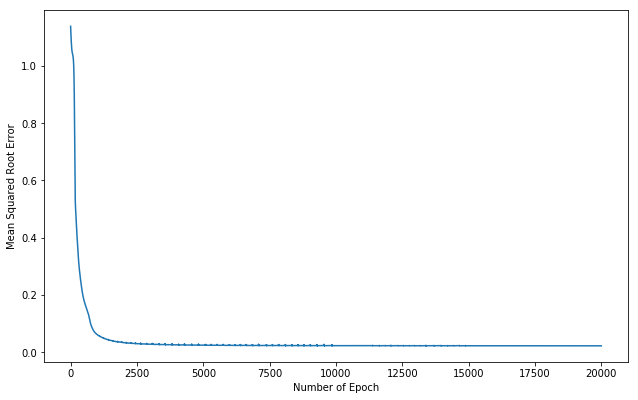

In [197]:
# Instantiate RNN model
model_plant_RNN = plant_RNN()
model_plant_RNN.cuda()
print(model_plant_RNN)

count,loss_graph = train_plant(model_plant_RNN,x_train, y_train)

plot_loss(count,loss_graph)

plant_LSTM(
  (lstm): LSTM(1, 8, num_layers=3, batch_first=True)
  (fc): Linear(in_features=8, out_features=4, bias=True)
)
epoch: 1, loss: 1.09574
epoch: 2, loss: 1.09502
epoch: 3, loss: 1.09431
epoch: 4, loss: 1.09361
epoch: 5, loss: 1.09292
epoch: 6, loss: 1.09225
epoch: 7, loss: 1.09158
epoch: 8, loss: 1.09093
epoch: 9, loss: 1.09028
epoch: 10, loss: 1.08965
epoch: 11, loss: 1.08902
epoch: 12, loss: 1.08840
epoch: 13, loss: 1.08779
epoch: 14, loss: 1.08718
epoch: 15, loss: 1.08659
epoch: 16, loss: 1.08600
epoch: 17, loss: 1.08542
epoch: 18, loss: 1.08485
epoch: 19, loss: 1.08429
epoch: 20, loss: 1.08373
epoch: 21, loss: 1.08318
epoch: 22, loss: 1.08264
epoch: 23, loss: 1.08211
epoch: 24, loss: 1.08158
epoch: 25, loss: 1.08106
epoch: 26, loss: 1.08055
epoch: 27, loss: 1.08004
epoch: 28, loss: 1.07954
epoch: 29, loss: 1.07905
epoch: 30, loss: 1.07856
epoch: 31, loss: 1.07808
epoch: 32, loss: 1.07761
epoch: 33, loss: 1.07714
epoch: 34, loss: 1.07667
epoch: 35, loss: 1.07622
epoch: 36,

epoch: 324, loss: 0.32356
epoch: 325, loss: 0.32141
epoch: 326, loss: 0.31930
epoch: 327, loss: 0.31721
epoch: 328, loss: 0.31515
epoch: 329, loss: 0.31313
epoch: 330, loss: 0.31114
epoch: 331, loss: 0.30918
epoch: 332, loss: 0.30725
epoch: 333, loss: 0.30535
epoch: 334, loss: 0.30348
epoch: 335, loss: 0.30164
epoch: 336, loss: 0.29983
epoch: 337, loss: 0.29805
epoch: 338, loss: 0.29629
epoch: 339, loss: 0.29456
epoch: 340, loss: 0.29286
epoch: 341, loss: 0.29118
epoch: 342, loss: 0.28953
epoch: 343, loss: 0.28790
epoch: 344, loss: 0.28629
epoch: 345, loss: 0.28471
epoch: 346, loss: 0.28315
epoch: 347, loss: 0.28162
epoch: 348, loss: 0.28010
epoch: 349, loss: 0.27860
epoch: 350, loss: 0.27713
epoch: 351, loss: 0.27567
epoch: 352, loss: 0.27424
epoch: 353, loss: 0.27282
epoch: 354, loss: 0.27142
epoch: 355, loss: 0.27004
epoch: 356, loss: 0.26867
epoch: 357, loss: 0.26732
epoch: 358, loss: 0.26598
epoch: 359, loss: 0.26466
epoch: 360, loss: 0.26335
epoch: 361, loss: 0.26206
epoch: 362, 

epoch: 643, loss: 0.10522
epoch: 644, loss: 0.10499
epoch: 645, loss: 0.10472
epoch: 646, loss: 0.10445
epoch: 647, loss: 0.10420
epoch: 648, loss: 0.10399
epoch: 649, loss: 0.10379
epoch: 650, loss: 0.10361
epoch: 651, loss: 0.10341
epoch: 652, loss: 0.10320
epoch: 653, loss: 0.10297
epoch: 654, loss: 0.10273
epoch: 655, loss: 0.10250
epoch: 656, loss: 0.10228
epoch: 657, loss: 0.10207
epoch: 658, loss: 0.10187
epoch: 659, loss: 0.10168
epoch: 660, loss: 0.10148
epoch: 661, loss: 0.10128
epoch: 662, loss: 0.10107
epoch: 663, loss: 0.10087
epoch: 664, loss: 0.10065
epoch: 665, loss: 0.10044
epoch: 666, loss: 0.10023
epoch: 667, loss: 0.10002
epoch: 668, loss: 0.09981
epoch: 669, loss: 0.09961
epoch: 670, loss: 0.09941
epoch: 671, loss: 0.09921
epoch: 672, loss: 0.09901
epoch: 673, loss: 0.09881
epoch: 674, loss: 0.09862
epoch: 675, loss: 0.09842
epoch: 676, loss: 0.09823
epoch: 677, loss: 0.09804
epoch: 678, loss: 0.09786
epoch: 679, loss: 0.09768
epoch: 680, loss: 0.09751
epoch: 681, 

epoch: 1008, loss: 0.05965
epoch: 1009, loss: 0.05959
epoch: 1010, loss: 0.05952
epoch: 1011, loss: 0.05946
epoch: 1012, loss: 0.05939
epoch: 1013, loss: 0.05933
epoch: 1014, loss: 0.05927
epoch: 1015, loss: 0.05921
epoch: 1016, loss: 0.05915
epoch: 1017, loss: 0.05908
epoch: 1018, loss: 0.05902
epoch: 1019, loss: 0.05896
epoch: 1020, loss: 0.05890
epoch: 1021, loss: 0.05884
epoch: 1022, loss: 0.05878
epoch: 1023, loss: 0.05872
epoch: 1024, loss: 0.05866
epoch: 1025, loss: 0.05860
epoch: 1026, loss: 0.05854
epoch: 1027, loss: 0.05848
epoch: 1028, loss: 0.05842
epoch: 1029, loss: 0.05836
epoch: 1030, loss: 0.05830
epoch: 1031, loss: 0.05824
epoch: 1032, loss: 0.05818
epoch: 1033, loss: 0.05812
epoch: 1034, loss: 0.05806
epoch: 1035, loss: 0.05800
epoch: 1036, loss: 0.05794
epoch: 1037, loss: 0.05789
epoch: 1038, loss: 0.05783
epoch: 1039, loss: 0.05777
epoch: 1040, loss: 0.05771
epoch: 1041, loss: 0.05765
epoch: 1042, loss: 0.05760
epoch: 1043, loss: 0.05754
epoch: 1044, loss: 0.05748
e

epoch: 1319, loss: 0.04645
epoch: 1320, loss: 0.04642
epoch: 1321, loss: 0.04639
epoch: 1322, loss: 0.04636
epoch: 1323, loss: 0.04633
epoch: 1324, loss: 0.04631
epoch: 1325, loss: 0.04628
epoch: 1326, loss: 0.04625
epoch: 1327, loss: 0.04622
epoch: 1328, loss: 0.04619
epoch: 1329, loss: 0.04617
epoch: 1330, loss: 0.04614
epoch: 1331, loss: 0.04611
epoch: 1332, loss: 0.04608
epoch: 1333, loss: 0.04606
epoch: 1334, loss: 0.04603
epoch: 1335, loss: 0.04600
epoch: 1336, loss: 0.04597
epoch: 1337, loss: 0.04595
epoch: 1338, loss: 0.04592
epoch: 1339, loss: 0.04589
epoch: 1340, loss: 0.04586
epoch: 1341, loss: 0.04584
epoch: 1342, loss: 0.04581
epoch: 1343, loss: 0.04578
epoch: 1344, loss: 0.04575
epoch: 1345, loss: 0.04573
epoch: 1346, loss: 0.04570
epoch: 1347, loss: 0.04567
epoch: 1348, loss: 0.04565
epoch: 1349, loss: 0.04562
epoch: 1350, loss: 0.04559
epoch: 1351, loss: 0.04557
epoch: 1352, loss: 0.04554
epoch: 1353, loss: 0.04551
epoch: 1354, loss: 0.04549
epoch: 1355, loss: 0.04546
e

epoch: 1669, loss: 0.03899
epoch: 1670, loss: 0.03901
epoch: 1671, loss: 0.03901
epoch: 1672, loss: 0.03897
epoch: 1673, loss: 0.03893
epoch: 1674, loss: 0.03892
epoch: 1675, loss: 0.03892
epoch: 1676, loss: 0.03891
epoch: 1677, loss: 0.03888
epoch: 1678, loss: 0.03885
epoch: 1679, loss: 0.03884
epoch: 1680, loss: 0.03883
epoch: 1681, loss: 0.03882
epoch: 1682, loss: 0.03879
epoch: 1683, loss: 0.03877
epoch: 1684, loss: 0.03876
epoch: 1685, loss: 0.03875
epoch: 1686, loss: 0.03873
epoch: 1687, loss: 0.03871
epoch: 1688, loss: 0.03869
epoch: 1689, loss: 0.03868
epoch: 1690, loss: 0.03867
epoch: 1691, loss: 0.03865
epoch: 1692, loss: 0.03863
epoch: 1693, loss: 0.03861
epoch: 1694, loss: 0.03860
epoch: 1695, loss: 0.03858
epoch: 1696, loss: 0.03857
epoch: 1697, loss: 0.03855
epoch: 1698, loss: 0.03853
epoch: 1699, loss: 0.03852
epoch: 1700, loss: 0.03850
epoch: 1701, loss: 0.03849
epoch: 1702, loss: 0.03847
epoch: 1703, loss: 0.03845
epoch: 1704, loss: 0.03844
epoch: 1705, loss: 0.03843
e

epoch: 1998, loss: 0.03444
epoch: 1999, loss: 0.03443
epoch: 2000, loss: 0.03441
epoch: 2001, loss: 0.03440
epoch: 2002, loss: 0.03439
epoch: 2003, loss: 0.03438
epoch: 2004, loss: 0.03436
epoch: 2005, loss: 0.03435
epoch: 2006, loss: 0.03434
epoch: 2007, loss: 0.03433
epoch: 2008, loss: 0.03432
epoch: 2009, loss: 0.03430
epoch: 2010, loss: 0.03429
epoch: 2011, loss: 0.03428
epoch: 2012, loss: 0.03427
epoch: 2013, loss: 0.03426
epoch: 2014, loss: 0.03425
epoch: 2015, loss: 0.03423
epoch: 2016, loss: 0.03422
epoch: 2017, loss: 0.03421
epoch: 2018, loss: 0.03420
epoch: 2019, loss: 0.03419
epoch: 2020, loss: 0.03417
epoch: 2021, loss: 0.03416
epoch: 2022, loss: 0.03415
epoch: 2023, loss: 0.03414
epoch: 2024, loss: 0.03413
epoch: 2025, loss: 0.03411
epoch: 2026, loss: 0.03410
epoch: 2027, loss: 0.03409
epoch: 2028, loss: 0.03408
epoch: 2029, loss: 0.03407
epoch: 2030, loss: 0.03406
epoch: 2031, loss: 0.03404
epoch: 2032, loss: 0.03403
epoch: 2033, loss: 0.03402
epoch: 2034, loss: 0.03401
e

epoch: 2313, loss: 0.03385
epoch: 2314, loss: 0.03413
epoch: 2315, loss: 0.03342
epoch: 2316, loss: 0.03212
epoch: 2317, loss: 0.03126
epoch: 2318, loss: 0.03149
epoch: 2319, loss: 0.03227
epoch: 2320, loss: 0.03255
epoch: 2321, loss: 0.03201
epoch: 2322, loss: 0.03130
epoch: 2323, loss: 0.03127
epoch: 2324, loss: 0.03174
epoch: 2325, loss: 0.03193
epoch: 2326, loss: 0.03158
epoch: 2327, loss: 0.03118
epoch: 2328, loss: 0.03123
epoch: 2329, loss: 0.03152
epoch: 2330, loss: 0.03156
epoch: 2331, loss: 0.03130
epoch: 2332, loss: 0.03111
epoch: 2333, loss: 0.03121
epoch: 2334, loss: 0.03137
epoch: 2335, loss: 0.03132
epoch: 2336, loss: 0.03114
epoch: 2337, loss: 0.03107
epoch: 2338, loss: 0.03116
epoch: 2339, loss: 0.03123
epoch: 2340, loss: 0.03116
epoch: 2341, loss: 0.03106
epoch: 2342, loss: 0.03104
epoch: 2343, loss: 0.03111
epoch: 2344, loss: 0.03112
epoch: 2345, loss: 0.03106
epoch: 2346, loss: 0.03100
epoch: 2347, loss: 0.03101
epoch: 2348, loss: 0.03104
epoch: 2349, loss: 0.03104
e

epoch: 2631, loss: 0.02923
epoch: 2632, loss: 0.02922
epoch: 2633, loss: 0.02922
epoch: 2634, loss: 0.02921
epoch: 2635, loss: 0.02921
epoch: 2636, loss: 0.02920
epoch: 2637, loss: 0.02920
epoch: 2638, loss: 0.02919
epoch: 2639, loss: 0.02919
epoch: 2640, loss: 0.02918
epoch: 2641, loss: 0.02918
epoch: 2642, loss: 0.02917
epoch: 2643, loss: 0.02917
epoch: 2644, loss: 0.02916
epoch: 2645, loss: 0.02916
epoch: 2646, loss: 0.02915
epoch: 2647, loss: 0.02915
epoch: 2648, loss: 0.02914
epoch: 2649, loss: 0.02914
epoch: 2650, loss: 0.02913
epoch: 2651, loss: 0.02913
epoch: 2652, loss: 0.02912
epoch: 2653, loss: 0.02912
epoch: 2654, loss: 0.02911
epoch: 2655, loss: 0.02911
epoch: 2656, loss: 0.02910
epoch: 2657, loss: 0.02910
epoch: 2658, loss: 0.02909
epoch: 2659, loss: 0.02909
epoch: 2660, loss: 0.02908
epoch: 2661, loss: 0.02908
epoch: 2662, loss: 0.02907
epoch: 2663, loss: 0.02907
epoch: 2664, loss: 0.02906
epoch: 2665, loss: 0.02906
epoch: 2666, loss: 0.02905
epoch: 2667, loss: 0.02905
e

epoch: 2951, loss: 0.02788
epoch: 2952, loss: 0.02788
epoch: 2953, loss: 0.02788
epoch: 2954, loss: 0.02787
epoch: 2955, loss: 0.02787
epoch: 2956, loss: 0.02786
epoch: 2957, loss: 0.02786
epoch: 2958, loss: 0.02786
epoch: 2959, loss: 0.02785
epoch: 2960, loss: 0.02785
epoch: 2961, loss: 0.02785
epoch: 2962, loss: 0.02784
epoch: 2963, loss: 0.02784
epoch: 2964, loss: 0.02784
epoch: 2965, loss: 0.02783
epoch: 2966, loss: 0.02783
epoch: 2967, loss: 0.02783
epoch: 2968, loss: 0.02782
epoch: 2969, loss: 0.02782
epoch: 2970, loss: 0.02782
epoch: 2971, loss: 0.02781
epoch: 2972, loss: 0.02781
epoch: 2973, loss: 0.02781
epoch: 2974, loss: 0.02780
epoch: 2975, loss: 0.02780
epoch: 2976, loss: 0.02779
epoch: 2977, loss: 0.02779
epoch: 2978, loss: 0.02779
epoch: 2979, loss: 0.02778
epoch: 2980, loss: 0.02778
epoch: 2981, loss: 0.02778
epoch: 2982, loss: 0.02777
epoch: 2983, loss: 0.02777
epoch: 2984, loss: 0.02777
epoch: 2985, loss: 0.02777
epoch: 2986, loss: 0.02777
epoch: 2987, loss: 0.02777
e

epoch: 3306, loss: 0.02684
epoch: 3307, loss: 0.02683
epoch: 3308, loss: 0.02683
epoch: 3309, loss: 0.02683
epoch: 3310, loss: 0.02683
epoch: 3311, loss: 0.02682
epoch: 3312, loss: 0.02682
epoch: 3313, loss: 0.02682
epoch: 3314, loss: 0.02681
epoch: 3315, loss: 0.02681
epoch: 3316, loss: 0.02681
epoch: 3317, loss: 0.02681
epoch: 3318, loss: 0.02680
epoch: 3319, loss: 0.02680
epoch: 3320, loss: 0.02680
epoch: 3321, loss: 0.02680
epoch: 3322, loss: 0.02679
epoch: 3323, loss: 0.02679
epoch: 3324, loss: 0.02679
epoch: 3325, loss: 0.02679
epoch: 3326, loss: 0.02678
epoch: 3327, loss: 0.02678
epoch: 3328, loss: 0.02678
epoch: 3329, loss: 0.02678
epoch: 3330, loss: 0.02677
epoch: 3331, loss: 0.02677
epoch: 3332, loss: 0.02677
epoch: 3333, loss: 0.02677
epoch: 3334, loss: 0.02676
epoch: 3335, loss: 0.02676
epoch: 3336, loss: 0.02676
epoch: 3337, loss: 0.02676
epoch: 3338, loss: 0.02675
epoch: 3339, loss: 0.02675
epoch: 3340, loss: 0.02675
epoch: 3341, loss: 0.02675
epoch: 3342, loss: 0.02674
e

epoch: 3622, loss: 0.02613
epoch: 3623, loss: 0.02613
epoch: 3624, loss: 0.02613
epoch: 3625, loss: 0.02612
epoch: 3626, loss: 0.02612
epoch: 3627, loss: 0.02612
epoch: 3628, loss: 0.02612
epoch: 3629, loss: 0.02612
epoch: 3630, loss: 0.02611
epoch: 3631, loss: 0.02611
epoch: 3632, loss: 0.02611
epoch: 3633, loss: 0.02611
epoch: 3634, loss: 0.02611
epoch: 3635, loss: 0.02610
epoch: 3636, loss: 0.02610
epoch: 3637, loss: 0.02610
epoch: 3638, loss: 0.02610
epoch: 3639, loss: 0.02610
epoch: 3640, loss: 0.02610
epoch: 3641, loss: 0.02609
epoch: 3642, loss: 0.02609
epoch: 3643, loss: 0.02609
epoch: 3644, loss: 0.02609
epoch: 3645, loss: 0.02609
epoch: 3646, loss: 0.02608
epoch: 3647, loss: 0.02608
epoch: 3648, loss: 0.02608
epoch: 3649, loss: 0.02608
epoch: 3650, loss: 0.02608
epoch: 3651, loss: 0.02607
epoch: 3652, loss: 0.02607
epoch: 3653, loss: 0.02607
epoch: 3654, loss: 0.02607
epoch: 3655, loss: 0.02607
epoch: 3656, loss: 0.02606
epoch: 3657, loss: 0.02606
epoch: 3658, loss: 0.02606
e

epoch: 3938, loss: 0.02557
epoch: 3939, loss: 0.02557
epoch: 3940, loss: 0.02557
epoch: 3941, loss: 0.02557
epoch: 3942, loss: 0.02557
epoch: 3943, loss: 0.02557
epoch: 3944, loss: 0.02556
epoch: 3945, loss: 0.02556
epoch: 3946, loss: 0.02556
epoch: 3947, loss: 0.02556
epoch: 3948, loss: 0.02556
epoch: 3949, loss: 0.02556
epoch: 3950, loss: 0.02555
epoch: 3951, loss: 0.02555
epoch: 3952, loss: 0.02555
epoch: 3953, loss: 0.02555
epoch: 3954, loss: 0.02555
epoch: 3955, loss: 0.02555
epoch: 3956, loss: 0.02555
epoch: 3957, loss: 0.02554
epoch: 3958, loss: 0.02554
epoch: 3959, loss: 0.02554
epoch: 3960, loss: 0.02554
epoch: 3961, loss: 0.02554
epoch: 3962, loss: 0.02554
epoch: 3963, loss: 0.02553
epoch: 3964, loss: 0.02553
epoch: 3965, loss: 0.02553
epoch: 3966, loss: 0.02553
epoch: 3967, loss: 0.02553
epoch: 3968, loss: 0.02553
epoch: 3969, loss: 0.02554
epoch: 3970, loss: 0.02555
epoch: 3971, loss: 0.02556
epoch: 3972, loss: 0.02559
epoch: 3973, loss: 0.02563
epoch: 3974, loss: 0.02572
e

epoch: 4288, loss: 0.02508
epoch: 4289, loss: 0.02507
epoch: 4290, loss: 0.02507
epoch: 4291, loss: 0.02507
epoch: 4292, loss: 0.02507
epoch: 4293, loss: 0.02507
epoch: 4294, loss: 0.02507
epoch: 4295, loss: 0.02507
epoch: 4296, loss: 0.02506
epoch: 4297, loss: 0.02506
epoch: 4298, loss: 0.02506
epoch: 4299, loss: 0.02506
epoch: 4300, loss: 0.02506
epoch: 4301, loss: 0.02506
epoch: 4302, loss: 0.02506
epoch: 4303, loss: 0.02505
epoch: 4304, loss: 0.02505
epoch: 4305, loss: 0.02505
epoch: 4306, loss: 0.02505
epoch: 4307, loss: 0.02505
epoch: 4308, loss: 0.02505
epoch: 4309, loss: 0.02505
epoch: 4310, loss: 0.02505
epoch: 4311, loss: 0.02504
epoch: 4312, loss: 0.02504
epoch: 4313, loss: 0.02504
epoch: 4314, loss: 0.02504
epoch: 4315, loss: 0.02504
epoch: 4316, loss: 0.02504
epoch: 4317, loss: 0.02504
epoch: 4318, loss: 0.02504
epoch: 4319, loss: 0.02503
epoch: 4320, loss: 0.02503
epoch: 4321, loss: 0.02503
epoch: 4322, loss: 0.02503
epoch: 4323, loss: 0.02503
epoch: 4324, loss: 0.02503
e

epoch: 4614, loss: 0.02467
epoch: 4615, loss: 0.02467
epoch: 4616, loss: 0.02467
epoch: 4617, loss: 0.02467
epoch: 4618, loss: 0.02466
epoch: 4619, loss: 0.02466
epoch: 4620, loss: 0.02466
epoch: 4621, loss: 0.02466
epoch: 4622, loss: 0.02466
epoch: 4623, loss: 0.02466
epoch: 4624, loss: 0.02466
epoch: 4625, loss: 0.02466
epoch: 4626, loss: 0.02466
epoch: 4627, loss: 0.02465
epoch: 4628, loss: 0.02465
epoch: 4629, loss: 0.02465
epoch: 4630, loss: 0.02465
epoch: 4631, loss: 0.02465
epoch: 4632, loss: 0.02465
epoch: 4633, loss: 0.02465
epoch: 4634, loss: 0.02465
epoch: 4635, loss: 0.02464
epoch: 4636, loss: 0.02464
epoch: 4637, loss: 0.02464
epoch: 4638, loss: 0.02464
epoch: 4639, loss: 0.02464
epoch: 4640, loss: 0.02464
epoch: 4641, loss: 0.02464
epoch: 4642, loss: 0.02464
epoch: 4643, loss: 0.02463
epoch: 4644, loss: 0.02463
epoch: 4645, loss: 0.02463
epoch: 4646, loss: 0.02463
epoch: 4647, loss: 0.02463
epoch: 4648, loss: 0.02463
epoch: 4649, loss: 0.02463
epoch: 4650, loss: 0.02463
e

epoch: 4931, loss: 0.02431
epoch: 4932, loss: 0.02431
epoch: 4933, loss: 0.02431
epoch: 4934, loss: 0.02431
epoch: 4935, loss: 0.02431
epoch: 4936, loss: 0.02431
epoch: 4937, loss: 0.02430
epoch: 4938, loss: 0.02430
epoch: 4939, loss: 0.02430
epoch: 4940, loss: 0.02430
epoch: 4941, loss: 0.02430
epoch: 4942, loss: 0.02430
epoch: 4943, loss: 0.02430
epoch: 4944, loss: 0.02430
epoch: 4945, loss: 0.02431
epoch: 4946, loss: 0.02432
epoch: 4947, loss: 0.02433
epoch: 4948, loss: 0.02435
epoch: 4949, loss: 0.02440
epoch: 4950, loss: 0.02447
epoch: 4951, loss: 0.02460
epoch: 4952, loss: 0.02481
epoch: 4953, loss: 0.02515
epoch: 4954, loss: 0.02569
epoch: 4955, loss: 0.02640
epoch: 4956, loss: 0.02719
epoch: 4957, loss: 0.02761
epoch: 4958, loss: 0.02724
epoch: 4959, loss: 0.02597
epoch: 4960, loss: 0.02469
epoch: 4961, loss: 0.02430
epoch: 4962, loss: 0.02489
epoch: 4963, loss: 0.02566
epoch: 4964, loss: 0.02577
epoch: 4965, loss: 0.02512
epoch: 4966, loss: 0.02441
epoch: 4967, loss: 0.02434
e

epoch: 5277, loss: 0.02395
epoch: 5278, loss: 0.02395
epoch: 5279, loss: 0.02395
epoch: 5280, loss: 0.02395
epoch: 5281, loss: 0.02395
epoch: 5282, loss: 0.02395
epoch: 5283, loss: 0.02395
epoch: 5284, loss: 0.02395
epoch: 5285, loss: 0.02395
epoch: 5286, loss: 0.02395
epoch: 5287, loss: 0.02394
epoch: 5288, loss: 0.02394
epoch: 5289, loss: 0.02394
epoch: 5290, loss: 0.02394
epoch: 5291, loss: 0.02394
epoch: 5292, loss: 0.02394
epoch: 5293, loss: 0.02394
epoch: 5294, loss: 0.02394
epoch: 5295, loss: 0.02394
epoch: 5296, loss: 0.02394
epoch: 5297, loss: 0.02393
epoch: 5298, loss: 0.02393
epoch: 5299, loss: 0.02393
epoch: 5300, loss: 0.02393
epoch: 5301, loss: 0.02393
epoch: 5302, loss: 0.02393
epoch: 5303, loss: 0.02393
epoch: 5304, loss: 0.02393
epoch: 5305, loss: 0.02393
epoch: 5306, loss: 0.02393
epoch: 5307, loss: 0.02392
epoch: 5308, loss: 0.02392
epoch: 5309, loss: 0.02392
epoch: 5310, loss: 0.02392
epoch: 5311, loss: 0.02392
epoch: 5312, loss: 0.02392
epoch: 5313, loss: 0.02392
e

epoch: 5584, loss: 0.02365
epoch: 5585, loss: 0.02365
epoch: 5586, loss: 0.02365
epoch: 5587, loss: 0.02365
epoch: 5588, loss: 0.02365
epoch: 5589, loss: 0.02365
epoch: 5590, loss: 0.02365
epoch: 5591, loss: 0.02365
epoch: 5592, loss: 0.02365
epoch: 5593, loss: 0.02365
epoch: 5594, loss: 0.02364
epoch: 5595, loss: 0.02364
epoch: 5596, loss: 0.02364
epoch: 5597, loss: 0.02364
epoch: 5598, loss: 0.02364
epoch: 5599, loss: 0.02364
epoch: 5600, loss: 0.02364
epoch: 5601, loss: 0.02364
epoch: 5602, loss: 0.02364
epoch: 5603, loss: 0.02364
epoch: 5604, loss: 0.02363
epoch: 5605, loss: 0.02363
epoch: 5606, loss: 0.02363
epoch: 5607, loss: 0.02363
epoch: 5608, loss: 0.02363
epoch: 5609, loss: 0.02363
epoch: 5610, loss: 0.02363
epoch: 5611, loss: 0.02363
epoch: 5612, loss: 0.02363
epoch: 5613, loss: 0.02363
epoch: 5614, loss: 0.02363
epoch: 5615, loss: 0.02362
epoch: 5616, loss: 0.02362
epoch: 5617, loss: 0.02362
epoch: 5618, loss: 0.02362
epoch: 5619, loss: 0.02362
epoch: 5620, loss: 0.02362
e

epoch: 5912, loss: 0.02344
epoch: 5913, loss: 0.02351
epoch: 5914, loss: 0.02363
epoch: 5915, loss: 0.02384
epoch: 5916, loss: 0.02415
epoch: 5917, loss: 0.02463
epoch: 5918, loss: 0.02527
epoch: 5919, loss: 0.02598
epoch: 5920, loss: 0.02641
epoch: 5921, loss: 0.02619
epoch: 5922, loss: 0.02516
epoch: 5923, loss: 0.02392
epoch: 5924, loss: 0.02333
epoch: 5925, loss: 0.02365
epoch: 5926, loss: 0.02437
epoch: 5927, loss: 0.02473
epoch: 5928, loss: 0.02438
epoch: 5929, loss: 0.02368
epoch: 5930, loss: 0.02332
epoch: 5931, loss: 0.02354
epoch: 5932, loss: 0.02395
epoch: 5933, loss: 0.02403
epoch: 5934, loss: 0.02371
epoch: 5935, loss: 0.02337
epoch: 5936, loss: 0.02334
epoch: 5937, loss: 0.02357
epoch: 5938, loss: 0.02373
epoch: 5939, loss: 0.02362
epoch: 5940, loss: 0.02340
epoch: 5941, loss: 0.02330
epoch: 5942, loss: 0.02340
epoch: 5943, loss: 0.02353
epoch: 5944, loss: 0.02352
epoch: 5945, loss: 0.02340
epoch: 5946, loss: 0.02330
epoch: 5947, loss: 0.02332
epoch: 5948, loss: 0.02340
e

epoch: 6217, loss: 0.02300
epoch: 6218, loss: 0.02299
epoch: 6219, loss: 0.02299
epoch: 6220, loss: 0.02299
epoch: 6221, loss: 0.02299
epoch: 6222, loss: 0.02299
epoch: 6223, loss: 0.02299
epoch: 6224, loss: 0.02298
epoch: 6225, loss: 0.02298
epoch: 6226, loss: 0.02298
epoch: 6227, loss: 0.02298
epoch: 6228, loss: 0.02298
epoch: 6229, loss: 0.02298
epoch: 6230, loss: 0.02297
epoch: 6231, loss: 0.02297
epoch: 6232, loss: 0.02297
epoch: 6233, loss: 0.02297
epoch: 6234, loss: 0.02297
epoch: 6235, loss: 0.02297
epoch: 6236, loss: 0.02297
epoch: 6237, loss: 0.02296
epoch: 6238, loss: 0.02296
epoch: 6239, loss: 0.02296
epoch: 6240, loss: 0.02296
epoch: 6241, loss: 0.02296
epoch: 6242, loss: 0.02296
epoch: 6243, loss: 0.02296
epoch: 6244, loss: 0.02296
epoch: 6245, loss: 0.02296
epoch: 6246, loss: 0.02295
epoch: 6247, loss: 0.02295
epoch: 6248, loss: 0.02295
epoch: 6249, loss: 0.02295
epoch: 6250, loss: 0.02295
epoch: 6251, loss: 0.02295
epoch: 6252, loss: 0.02295
epoch: 6253, loss: 0.02294
e

epoch: 6546, loss: 0.02248
epoch: 6547, loss: 0.02247
epoch: 6548, loss: 0.02247
epoch: 6549, loss: 0.02247
epoch: 6550, loss: 0.02247
epoch: 6551, loss: 0.02247
epoch: 6552, loss: 0.02246
epoch: 6553, loss: 0.02246
epoch: 6554, loss: 0.02246
epoch: 6555, loss: 0.02246
epoch: 6556, loss: 0.02246
epoch: 6557, loss: 0.02245
epoch: 6558, loss: 0.02245
epoch: 6559, loss: 0.02245
epoch: 6560, loss: 0.02245
epoch: 6561, loss: 0.02245
epoch: 6562, loss: 0.02244
epoch: 6563, loss: 0.02244
epoch: 6564, loss: 0.02244
epoch: 6565, loss: 0.02244
epoch: 6566, loss: 0.02243
epoch: 6567, loss: 0.02243
epoch: 6568, loss: 0.02243
epoch: 6569, loss: 0.02243
epoch: 6570, loss: 0.02243
epoch: 6571, loss: 0.02242
epoch: 6572, loss: 0.02242
epoch: 6573, loss: 0.02242
epoch: 6574, loss: 0.02242
epoch: 6575, loss: 0.02242
epoch: 6576, loss: 0.02241
epoch: 6577, loss: 0.02241
epoch: 6578, loss: 0.02241
epoch: 6579, loss: 0.02241
epoch: 6580, loss: 0.02240
epoch: 6581, loss: 0.02240
epoch: 6582, loss: 0.02240
e

epoch: 6857, loss: 0.02157
epoch: 6858, loss: 0.02157
epoch: 6859, loss: 0.02156
epoch: 6860, loss: 0.02156
epoch: 6861, loss: 0.02155
epoch: 6862, loss: 0.02155
epoch: 6863, loss: 0.02154
epoch: 6864, loss: 0.02154
epoch: 6865, loss: 0.02153
epoch: 6866, loss: 0.02153
epoch: 6867, loss: 0.02153
epoch: 6868, loss: 0.02152
epoch: 6869, loss: 0.02152
epoch: 6870, loss: 0.02151
epoch: 6871, loss: 0.02151
epoch: 6872, loss: 0.02150
epoch: 6873, loss: 0.02150
epoch: 6874, loss: 0.02149
epoch: 6875, loss: 0.02149
epoch: 6876, loss: 0.02149
epoch: 6877, loss: 0.02148
epoch: 6878, loss: 0.02148
epoch: 6879, loss: 0.02147
epoch: 6880, loss: 0.02147
epoch: 6881, loss: 0.02146
epoch: 6882, loss: 0.02146
epoch: 6883, loss: 0.02146
epoch: 6884, loss: 0.02145
epoch: 6885, loss: 0.02145
epoch: 6886, loss: 0.02145
epoch: 6887, loss: 0.02146
epoch: 6888, loss: 0.02148
epoch: 6889, loss: 0.02150
epoch: 6890, loss: 0.02155
epoch: 6891, loss: 0.02164
epoch: 6892, loss: 0.02179
epoch: 6893, loss: 0.02204
e

epoch: 7206, loss: 0.01912
epoch: 7207, loss: 0.01911
epoch: 7208, loss: 0.01910
epoch: 7209, loss: 0.01908
epoch: 7210, loss: 0.01907
epoch: 7211, loss: 0.01906
epoch: 7212, loss: 0.01905
epoch: 7213, loss: 0.01904
epoch: 7214, loss: 0.01903
epoch: 7215, loss: 0.01902
epoch: 7216, loss: 0.01901
epoch: 7217, loss: 0.01900
epoch: 7218, loss: 0.01899
epoch: 7219, loss: 0.01898
epoch: 7220, loss: 0.01896
epoch: 7221, loss: 0.01895
epoch: 7222, loss: 0.01894
epoch: 7223, loss: 0.01893
epoch: 7224, loss: 0.01892
epoch: 7225, loss: 0.01891
epoch: 7226, loss: 0.01890
epoch: 7227, loss: 0.01889
epoch: 7228, loss: 0.01887
epoch: 7229, loss: 0.01886
epoch: 7230, loss: 0.01885
epoch: 7231, loss: 0.01884
epoch: 7232, loss: 0.01883
epoch: 7233, loss: 0.01882
epoch: 7234, loss: 0.01881
epoch: 7235, loss: 0.01879
epoch: 7236, loss: 0.01878
epoch: 7237, loss: 0.01877
epoch: 7238, loss: 0.01876
epoch: 7239, loss: 0.01875
epoch: 7240, loss: 0.01874
epoch: 7241, loss: 0.01872
epoch: 7242, loss: 0.01871
e

epoch: 7519, loss: 0.01415
epoch: 7520, loss: 0.01413
epoch: 7521, loss: 0.01410
epoch: 7522, loss: 0.01408
epoch: 7523, loss: 0.01406
epoch: 7524, loss: 0.01404
epoch: 7525, loss: 0.01401
epoch: 7526, loss: 0.01399
epoch: 7527, loss: 0.01397
epoch: 7528, loss: 0.01394
epoch: 7529, loss: 0.01392
epoch: 7530, loss: 0.01390
epoch: 7531, loss: 0.01387
epoch: 7532, loss: 0.01385
epoch: 7533, loss: 0.01383
epoch: 7534, loss: 0.01380
epoch: 7535, loss: 0.01378
epoch: 7536, loss: 0.01375
epoch: 7537, loss: 0.01373
epoch: 7538, loss: 0.01371
epoch: 7539, loss: 0.01368
epoch: 7540, loss: 0.01366
epoch: 7541, loss: 0.01363
epoch: 7542, loss: 0.01361
epoch: 7543, loss: 0.01359
epoch: 7544, loss: 0.01356
epoch: 7545, loss: 0.01354
epoch: 7546, loss: 0.01351
epoch: 7547, loss: 0.01349
epoch: 7548, loss: 0.01346
epoch: 7549, loss: 0.01344
epoch: 7550, loss: 0.01341
epoch: 7551, loss: 0.01339
epoch: 7552, loss: 0.01336
epoch: 7553, loss: 0.01334
epoch: 7554, loss: 0.01331
epoch: 7555, loss: 0.01329
e

epoch: 7824, loss: 0.00753
epoch: 7825, loss: 0.00752
epoch: 7826, loss: 0.00751
epoch: 7827, loss: 0.00749
epoch: 7828, loss: 0.00748
epoch: 7829, loss: 0.00747
epoch: 7830, loss: 0.00746
epoch: 7831, loss: 0.00745
epoch: 7832, loss: 0.00744
epoch: 7833, loss: 0.00742
epoch: 7834, loss: 0.00741
epoch: 7835, loss: 0.00740
epoch: 7836, loss: 0.00739
epoch: 7837, loss: 0.00738
epoch: 7838, loss: 0.00737
epoch: 7839, loss: 0.00736
epoch: 7840, loss: 0.00735
epoch: 7841, loss: 0.00734
epoch: 7842, loss: 0.00732
epoch: 7843, loss: 0.00731
epoch: 7844, loss: 0.00730
epoch: 7845, loss: 0.00729
epoch: 7846, loss: 0.00728
epoch: 7847, loss: 0.00727
epoch: 7848, loss: 0.00726
epoch: 7849, loss: 0.00725
epoch: 7850, loss: 0.00724
epoch: 7851, loss: 0.00723
epoch: 7852, loss: 0.00722
epoch: 7853, loss: 0.00721
epoch: 7854, loss: 0.00720
epoch: 7855, loss: 0.00718
epoch: 7856, loss: 0.00717
epoch: 7857, loss: 0.00716
epoch: 7858, loss: 0.00715
epoch: 7859, loss: 0.00714
epoch: 7860, loss: 0.00713
e

epoch: 8176, loss: 0.00504
epoch: 8177, loss: 0.00503
epoch: 8178, loss: 0.00503
epoch: 8179, loss: 0.00502
epoch: 8180, loss: 0.00502
epoch: 8181, loss: 0.00501
epoch: 8182, loss: 0.00501
epoch: 8183, loss: 0.00501
epoch: 8184, loss: 0.00500
epoch: 8185, loss: 0.00500
epoch: 8186, loss: 0.00499
epoch: 8187, loss: 0.00499
epoch: 8188, loss: 0.00498
epoch: 8189, loss: 0.00498
epoch: 8190, loss: 0.00498
epoch: 8191, loss: 0.00497
epoch: 8192, loss: 0.00497
epoch: 8193, loss: 0.00496
epoch: 8194, loss: 0.00496
epoch: 8195, loss: 0.00495
epoch: 8196, loss: 0.00495
epoch: 8197, loss: 0.00495
epoch: 8198, loss: 0.00494
epoch: 8199, loss: 0.00494
epoch: 8200, loss: 0.00493
epoch: 8201, loss: 0.00493
epoch: 8202, loss: 0.00492
epoch: 8203, loss: 0.00492
epoch: 8204, loss: 0.00492
epoch: 8205, loss: 0.00491
epoch: 8206, loss: 0.00491
epoch: 8207, loss: 0.00490
epoch: 8208, loss: 0.00490
epoch: 8209, loss: 0.00490
epoch: 8210, loss: 0.00489
epoch: 8211, loss: 0.00489
epoch: 8212, loss: 0.00488
e

epoch: 8491, loss: 0.00404
epoch: 8492, loss: 0.00404
epoch: 8493, loss: 0.00403
epoch: 8494, loss: 0.00401
epoch: 8495, loss: 0.00401
epoch: 8496, loss: 0.00401
epoch: 8497, loss: 0.00402
epoch: 8498, loss: 0.00401
epoch: 8499, loss: 0.00400
epoch: 8500, loss: 0.00400
epoch: 8501, loss: 0.00400
epoch: 8502, loss: 0.00400
epoch: 8503, loss: 0.00400
epoch: 8504, loss: 0.00399
epoch: 8505, loss: 0.00399
epoch: 8506, loss: 0.00398
epoch: 8507, loss: 0.00398
epoch: 8508, loss: 0.00398
epoch: 8509, loss: 0.00398
epoch: 8510, loss: 0.00398
epoch: 8511, loss: 0.00397
epoch: 8512, loss: 0.00397
epoch: 8513, loss: 0.00397
epoch: 8514, loss: 0.00397
epoch: 8515, loss: 0.00396
epoch: 8516, loss: 0.00396
epoch: 8517, loss: 0.00396
epoch: 8518, loss: 0.00396
epoch: 8519, loss: 0.00395
epoch: 8520, loss: 0.00395
epoch: 8521, loss: 0.00395
epoch: 8522, loss: 0.00395
epoch: 8523, loss: 0.00395
epoch: 8524, loss: 0.00394
epoch: 8525, loss: 0.00394
epoch: 8526, loss: 0.00394
epoch: 8527, loss: 0.00394
e

epoch: 8820, loss: 0.00340
epoch: 8821, loss: 0.00340
epoch: 8822, loss: 0.00340
epoch: 8823, loss: 0.00340
epoch: 8824, loss: 0.00340
epoch: 8825, loss: 0.00340
epoch: 8826, loss: 0.00339
epoch: 8827, loss: 0.00339
epoch: 8828, loss: 0.00339
epoch: 8829, loss: 0.00339
epoch: 8830, loss: 0.00339
epoch: 8831, loss: 0.00339
epoch: 8832, loss: 0.00339
epoch: 8833, loss: 0.00338
epoch: 8834, loss: 0.00338
epoch: 8835, loss: 0.00338
epoch: 8836, loss: 0.00338
epoch: 8837, loss: 0.00338
epoch: 8838, loss: 0.00338
epoch: 8839, loss: 0.00338
epoch: 8840, loss: 0.00337
epoch: 8841, loss: 0.00337
epoch: 8842, loss: 0.00337
epoch: 8843, loss: 0.00337
epoch: 8844, loss: 0.00337
epoch: 8845, loss: 0.00337
epoch: 8846, loss: 0.00337
epoch: 8847, loss: 0.00336
epoch: 8848, loss: 0.00336
epoch: 8849, loss: 0.00336
epoch: 8850, loss: 0.00336
epoch: 8851, loss: 0.00336
epoch: 8852, loss: 0.00336
epoch: 8853, loss: 0.00336
epoch: 8854, loss: 0.00335
epoch: 8855, loss: 0.00335
epoch: 8856, loss: 0.00335
e

epoch: 9150, loss: 0.00300
epoch: 9151, loss: 0.00300
epoch: 9152, loss: 0.00300
epoch: 9153, loss: 0.00299
epoch: 9154, loss: 0.00299
epoch: 9155, loss: 0.00299
epoch: 9156, loss: 0.00299
epoch: 9157, loss: 0.00299
epoch: 9158, loss: 0.00299
epoch: 9159, loss: 0.00299
epoch: 9160, loss: 0.00299
epoch: 9161, loss: 0.00299
epoch: 9162, loss: 0.00298
epoch: 9163, loss: 0.00298
epoch: 9164, loss: 0.00298
epoch: 9165, loss: 0.00298
epoch: 9166, loss: 0.00298
epoch: 9167, loss: 0.00298
epoch: 9168, loss: 0.00298
epoch: 9169, loss: 0.00298
epoch: 9170, loss: 0.00298
epoch: 9171, loss: 0.00298
epoch: 9172, loss: 0.00298
epoch: 9173, loss: 0.00298
epoch: 9174, loss: 0.00298
epoch: 9175, loss: 0.00298
epoch: 9176, loss: 0.00298
epoch: 9177, loss: 0.00299
epoch: 9178, loss: 0.00301
epoch: 9179, loss: 0.00303
epoch: 9180, loss: 0.00307
epoch: 9181, loss: 0.00315
epoch: 9182, loss: 0.00327
epoch: 9183, loss: 0.00348
epoch: 9184, loss: 0.00382
epoch: 9185, loss: 0.00434
epoch: 9186, loss: 0.00509
e

epoch: 9476, loss: 0.00275
epoch: 9477, loss: 0.00276
epoch: 9478, loss: 0.00274
epoch: 9479, loss: 0.00271
epoch: 9480, loss: 0.00271
epoch: 9481, loss: 0.00273
epoch: 9482, loss: 0.00274
epoch: 9483, loss: 0.00272
epoch: 9484, loss: 0.00271
epoch: 9485, loss: 0.00270
epoch: 9486, loss: 0.00271
epoch: 9487, loss: 0.00272
epoch: 9488, loss: 0.00271
epoch: 9489, loss: 0.00270
epoch: 9490, loss: 0.00270
epoch: 9491, loss: 0.00270
epoch: 9492, loss: 0.00271
epoch: 9493, loss: 0.00271
epoch: 9494, loss: 0.00270
epoch: 9495, loss: 0.00270
epoch: 9496, loss: 0.00270
epoch: 9497, loss: 0.00270
epoch: 9498, loss: 0.00270
epoch: 9499, loss: 0.00270
epoch: 9500, loss: 0.00269
epoch: 9501, loss: 0.00269
epoch: 9502, loss: 0.00269
epoch: 9503, loss: 0.00269
epoch: 9504, loss: 0.00269
epoch: 9505, loss: 0.00269
epoch: 9506, loss: 0.00269
epoch: 9507, loss: 0.00269
epoch: 9508, loss: 0.00269
epoch: 9509, loss: 0.00269
epoch: 9510, loss: 0.00269
epoch: 9511, loss: 0.00268
epoch: 9512, loss: 0.00268
e

epoch: 9798, loss: 0.00249
epoch: 9799, loss: 0.00249
epoch: 9800, loss: 0.00249
epoch: 9801, loss: 0.00249
epoch: 9802, loss: 0.00249
epoch: 9803, loss: 0.00249
epoch: 9804, loss: 0.00249
epoch: 9805, loss: 0.00249
epoch: 9806, loss: 0.00249
epoch: 9807, loss: 0.00249
epoch: 9808, loss: 0.00248
epoch: 9809, loss: 0.00248
epoch: 9810, loss: 0.00248
epoch: 9811, loss: 0.00248
epoch: 9812, loss: 0.00248
epoch: 9813, loss: 0.00248
epoch: 9814, loss: 0.00248
epoch: 9815, loss: 0.00248
epoch: 9816, loss: 0.00248
epoch: 9817, loss: 0.00248
epoch: 9818, loss: 0.00248
epoch: 9819, loss: 0.00248
epoch: 9820, loss: 0.00248
epoch: 9821, loss: 0.00248
epoch: 9822, loss: 0.00248
epoch: 9823, loss: 0.00248
epoch: 9824, loss: 0.00247
epoch: 9825, loss: 0.00247
epoch: 9826, loss: 0.00247
epoch: 9827, loss: 0.00247
epoch: 9828, loss: 0.00247
epoch: 9829, loss: 0.00247
epoch: 9830, loss: 0.00247
epoch: 9831, loss: 0.00247
epoch: 9832, loss: 0.00247
epoch: 9833, loss: 0.00247
epoch: 9834, loss: 0.00247
e

epoch: 10141, loss: 0.00234
epoch: 10142, loss: 0.00234
epoch: 10143, loss: 0.00234
epoch: 10144, loss: 0.00234
epoch: 10145, loss: 0.00234
epoch: 10146, loss: 0.00234
epoch: 10147, loss: 0.00234
epoch: 10148, loss: 0.00234
epoch: 10149, loss: 0.00234
epoch: 10150, loss: 0.00234
epoch: 10151, loss: 0.00234
epoch: 10152, loss: 0.00234
epoch: 10153, loss: 0.00234
epoch: 10154, loss: 0.00234
epoch: 10155, loss: 0.00234
epoch: 10156, loss: 0.00234
epoch: 10157, loss: 0.00234
epoch: 10158, loss: 0.00234
epoch: 10159, loss: 0.00233
epoch: 10160, loss: 0.00233
epoch: 10161, loss: 0.00233
epoch: 10162, loss: 0.00233
epoch: 10163, loss: 0.00233
epoch: 10164, loss: 0.00233
epoch: 10165, loss: 0.00233
epoch: 10166, loss: 0.00233
epoch: 10167, loss: 0.00233
epoch: 10168, loss: 0.00233
epoch: 10169, loss: 0.00233
epoch: 10170, loss: 0.00233
epoch: 10171, loss: 0.00233
epoch: 10172, loss: 0.00233
epoch: 10173, loss: 0.00233
epoch: 10174, loss: 0.00233
epoch: 10175, loss: 0.00233
epoch: 10176, loss: 

epoch: 10476, loss: 0.00225
epoch: 10477, loss: 0.00225
epoch: 10478, loss: 0.00225
epoch: 10479, loss: 0.00225
epoch: 10480, loss: 0.00225
epoch: 10481, loss: 0.00225
epoch: 10482, loss: 0.00225
epoch: 10483, loss: 0.00225
epoch: 10484, loss: 0.00225
epoch: 10485, loss: 0.00225
epoch: 10486, loss: 0.00225
epoch: 10487, loss: 0.00225
epoch: 10488, loss: 0.00225
epoch: 10489, loss: 0.00225
epoch: 10490, loss: 0.00225
epoch: 10491, loss: 0.00225
epoch: 10492, loss: 0.00225
epoch: 10493, loss: 0.00225
epoch: 10494, loss: 0.00225
epoch: 10495, loss: 0.00225
epoch: 10496, loss: 0.00225
epoch: 10497, loss: 0.00225
epoch: 10498, loss: 0.00224
epoch: 10499, loss: 0.00224
epoch: 10500, loss: 0.00224
epoch: 10501, loss: 0.00224
epoch: 10502, loss: 0.00224
epoch: 10503, loss: 0.00224
epoch: 10504, loss: 0.00224
epoch: 10505, loss: 0.00224
epoch: 10506, loss: 0.00224
epoch: 10507, loss: 0.00224
epoch: 10508, loss: 0.00224
epoch: 10509, loss: 0.00224
epoch: 10510, loss: 0.00224
epoch: 10511, loss: 

epoch: 10810, loss: 0.00216
epoch: 10811, loss: 0.00216
epoch: 10812, loss: 0.00216
epoch: 10813, loss: 0.00216
epoch: 10814, loss: 0.00216
epoch: 10815, loss: 0.00216
epoch: 10816, loss: 0.00216
epoch: 10817, loss: 0.00216
epoch: 10818, loss: 0.00216
epoch: 10819, loss: 0.00216
epoch: 10820, loss: 0.00216
epoch: 10821, loss: 0.00216
epoch: 10822, loss: 0.00216
epoch: 10823, loss: 0.00216
epoch: 10824, loss: 0.00216
epoch: 10825, loss: 0.00215
epoch: 10826, loss: 0.00215
epoch: 10827, loss: 0.00215
epoch: 10828, loss: 0.00215
epoch: 10829, loss: 0.00215
epoch: 10830, loss: 0.00215
epoch: 10831, loss: 0.00215
epoch: 10832, loss: 0.00215
epoch: 10833, loss: 0.00215
epoch: 10834, loss: 0.00215
epoch: 10835, loss: 0.00215
epoch: 10836, loss: 0.00215
epoch: 10837, loss: 0.00215
epoch: 10838, loss: 0.00215
epoch: 10839, loss: 0.00215
epoch: 10840, loss: 0.00215
epoch: 10841, loss: 0.00215
epoch: 10842, loss: 0.00215
epoch: 10843, loss: 0.00215
epoch: 10844, loss: 0.00215
epoch: 10845, loss: 

epoch: 11124, loss: 0.00207
epoch: 11125, loss: 0.00207
epoch: 11126, loss: 0.00207
epoch: 11127, loss: 0.00207
epoch: 11128, loss: 0.00207
epoch: 11129, loss: 0.00207
epoch: 11130, loss: 0.00207
epoch: 11131, loss: 0.00207
epoch: 11132, loss: 0.00207
epoch: 11133, loss: 0.00207
epoch: 11134, loss: 0.00207
epoch: 11135, loss: 0.00207
epoch: 11136, loss: 0.00207
epoch: 11137, loss: 0.00207
epoch: 11138, loss: 0.00207
epoch: 11139, loss: 0.00207
epoch: 11140, loss: 0.00207
epoch: 11141, loss: 0.00207
epoch: 11142, loss: 0.00207
epoch: 11143, loss: 0.00207
epoch: 11144, loss: 0.00206
epoch: 11145, loss: 0.00206
epoch: 11146, loss: 0.00206
epoch: 11147, loss: 0.00206
epoch: 11148, loss: 0.00206
epoch: 11149, loss: 0.00206
epoch: 11150, loss: 0.00206
epoch: 11151, loss: 0.00206
epoch: 11152, loss: 0.00206
epoch: 11153, loss: 0.00206
epoch: 11154, loss: 0.00206
epoch: 11155, loss: 0.00206
epoch: 11156, loss: 0.00206
epoch: 11157, loss: 0.00206
epoch: 11158, loss: 0.00206
epoch: 11159, loss: 

epoch: 11458, loss: 0.00197
epoch: 11459, loss: 0.00197
epoch: 11460, loss: 0.00197
epoch: 11461, loss: 0.00197
epoch: 11462, loss: 0.00197
epoch: 11463, loss: 0.00197
epoch: 11464, loss: 0.00197
epoch: 11465, loss: 0.00197
epoch: 11466, loss: 0.00197
epoch: 11467, loss: 0.00197
epoch: 11468, loss: 0.00197
epoch: 11469, loss: 0.00197
epoch: 11470, loss: 0.00197
epoch: 11471, loss: 0.00197
epoch: 11472, loss: 0.00197
epoch: 11473, loss: 0.00197
epoch: 11474, loss: 0.00197
epoch: 11475, loss: 0.00197
epoch: 11476, loss: 0.00197
epoch: 11477, loss: 0.00197
epoch: 11478, loss: 0.00197
epoch: 11479, loss: 0.00197
epoch: 11480, loss: 0.00197
epoch: 11481, loss: 0.00197
epoch: 11482, loss: 0.00197
epoch: 11483, loss: 0.00197
epoch: 11484, loss: 0.00197
epoch: 11485, loss: 0.00197
epoch: 11486, loss: 0.00197
epoch: 11487, loss: 0.00197
epoch: 11488, loss: 0.00197
epoch: 11489, loss: 0.00197
epoch: 11490, loss: 0.00197
epoch: 11491, loss: 0.00196
epoch: 11492, loss: 0.00196
epoch: 11493, loss: 

epoch: 11781, loss: 0.00189
epoch: 11782, loss: 0.00189
epoch: 11783, loss: 0.00190
epoch: 11784, loss: 0.00190
epoch: 11785, loss: 0.00191
epoch: 11786, loss: 0.00193
epoch: 11787, loss: 0.00195
epoch: 11788, loss: 0.00199
epoch: 11789, loss: 0.00206
epoch: 11790, loss: 0.00216
epoch: 11791, loss: 0.00231
epoch: 11792, loss: 0.00249
epoch: 11793, loss: 0.00268
epoch: 11794, loss: 0.00277
epoch: 11795, loss: 0.00268
epoch: 11796, loss: 0.00238
epoch: 11797, loss: 0.00205
epoch: 11798, loss: 0.00188
epoch: 11799, loss: 0.00196
epoch: 11800, loss: 0.00215
epoch: 11801, loss: 0.00226
epoch: 11802, loss: 0.00220
epoch: 11803, loss: 0.00202
epoch: 11804, loss: 0.00189
epoch: 11805, loss: 0.00191
epoch: 11806, loss: 0.00201
epoch: 11807, loss: 0.00208
epoch: 11808, loss: 0.00204
epoch: 11809, loss: 0.00194
epoch: 11810, loss: 0.00188
epoch: 11811, loss: 0.00191
epoch: 11812, loss: 0.00197
epoch: 11813, loss: 0.00199
epoch: 11814, loss: 0.00195
epoch: 11815, loss: 0.00189
epoch: 11816, loss: 

epoch: 12108, loss: 0.00181
epoch: 12109, loss: 0.00181
epoch: 12110, loss: 0.00181
epoch: 12111, loss: 0.00181
epoch: 12112, loss: 0.00180
epoch: 12113, loss: 0.00180
epoch: 12114, loss: 0.00180
epoch: 12115, loss: 0.00180
epoch: 12116, loss: 0.00180
epoch: 12117, loss: 0.00180
epoch: 12118, loss: 0.00180
epoch: 12119, loss: 0.00180
epoch: 12120, loss: 0.00180
epoch: 12121, loss: 0.00180
epoch: 12122, loss: 0.00180
epoch: 12123, loss: 0.00180
epoch: 12124, loss: 0.00180
epoch: 12125, loss: 0.00180
epoch: 12126, loss: 0.00180
epoch: 12127, loss: 0.00180
epoch: 12128, loss: 0.00180
epoch: 12129, loss: 0.00180
epoch: 12130, loss: 0.00180
epoch: 12131, loss: 0.00180
epoch: 12132, loss: 0.00180
epoch: 12133, loss: 0.00180
epoch: 12134, loss: 0.00180
epoch: 12135, loss: 0.00180
epoch: 12136, loss: 0.00180
epoch: 12137, loss: 0.00180
epoch: 12138, loss: 0.00180
epoch: 12139, loss: 0.00180
epoch: 12140, loss: 0.00180
epoch: 12141, loss: 0.00180
epoch: 12142, loss: 0.00180
epoch: 12143, loss: 

epoch: 12439, loss: 0.00198
epoch: 12440, loss: 0.00212
epoch: 12441, loss: 0.00229
epoch: 12442, loss: 0.00247
epoch: 12443, loss: 0.00260
epoch: 12444, loss: 0.00256
epoch: 12445, loss: 0.00232
epoch: 12446, loss: 0.00199
epoch: 12447, loss: 0.00176
epoch: 12448, loss: 0.00176
epoch: 12449, loss: 0.00192
epoch: 12450, loss: 0.00208
epoch: 12451, loss: 0.00208
epoch: 12452, loss: 0.00193
epoch: 12453, loss: 0.00177
epoch: 12454, loss: 0.00174
epoch: 12455, loss: 0.00182
epoch: 12456, loss: 0.00191
epoch: 12457, loss: 0.00191
epoch: 12458, loss: 0.00182
epoch: 12459, loss: 0.00174
epoch: 12460, loss: 0.00174
epoch: 12461, loss: 0.00179
epoch: 12462, loss: 0.00183
epoch: 12463, loss: 0.00181
epoch: 12464, loss: 0.00176
epoch: 12465, loss: 0.00173
epoch: 12466, loss: 0.00174
epoch: 12467, loss: 0.00177
epoch: 12468, loss: 0.00178
epoch: 12469, loss: 0.00177
epoch: 12470, loss: 0.00174
epoch: 12471, loss: 0.00173
epoch: 12472, loss: 0.00174
epoch: 12473, loss: 0.00175
epoch: 12474, loss: 

epoch: 12772, loss: 0.00167
epoch: 12773, loss: 0.00167
epoch: 12774, loss: 0.00166
epoch: 12775, loss: 0.00166
epoch: 12776, loss: 0.00166
epoch: 12777, loss: 0.00166
epoch: 12778, loss: 0.00166
epoch: 12779, loss: 0.00166
epoch: 12780, loss: 0.00166
epoch: 12781, loss: 0.00166
epoch: 12782, loss: 0.00166
epoch: 12783, loss: 0.00166
epoch: 12784, loss: 0.00166
epoch: 12785, loss: 0.00166
epoch: 12786, loss: 0.00166
epoch: 12787, loss: 0.00166
epoch: 12788, loss: 0.00166
epoch: 12789, loss: 0.00166
epoch: 12790, loss: 0.00166
epoch: 12791, loss: 0.00166
epoch: 12792, loss: 0.00166
epoch: 12793, loss: 0.00166
epoch: 12794, loss: 0.00166
epoch: 12795, loss: 0.00166
epoch: 12796, loss: 0.00166
epoch: 12797, loss: 0.00166
epoch: 12798, loss: 0.00166
epoch: 12799, loss: 0.00166
epoch: 12800, loss: 0.00166
epoch: 12801, loss: 0.00166
epoch: 12802, loss: 0.00166
epoch: 12803, loss: 0.00166
epoch: 12804, loss: 0.00166
epoch: 12805, loss: 0.00166
epoch: 12806, loss: 0.00166
epoch: 12807, loss: 

epoch: 13101, loss: 0.00160
epoch: 13102, loss: 0.00161
epoch: 13103, loss: 0.00161
epoch: 13104, loss: 0.00161
epoch: 13105, loss: 0.00161
epoch: 13106, loss: 0.00160
epoch: 13107, loss: 0.00160
epoch: 13108, loss: 0.00160
epoch: 13109, loss: 0.00160
epoch: 13110, loss: 0.00160
epoch: 13111, loss: 0.00160
epoch: 13112, loss: 0.00160
epoch: 13113, loss: 0.00160
epoch: 13114, loss: 0.00160
epoch: 13115, loss: 0.00160
epoch: 13116, loss: 0.00160
epoch: 13117, loss: 0.00160
epoch: 13118, loss: 0.00160
epoch: 13119, loss: 0.00160
epoch: 13120, loss: 0.00160
epoch: 13121, loss: 0.00160
epoch: 13122, loss: 0.00160
epoch: 13123, loss: 0.00160
epoch: 13124, loss: 0.00160
epoch: 13125, loss: 0.00160
epoch: 13126, loss: 0.00160
epoch: 13127, loss: 0.00160
epoch: 13128, loss: 0.00160
epoch: 13129, loss: 0.00160
epoch: 13130, loss: 0.00160
epoch: 13131, loss: 0.00160
epoch: 13132, loss: 0.00160
epoch: 13133, loss: 0.00160
epoch: 13134, loss: 0.00160
epoch: 13135, loss: 0.00160
epoch: 13136, loss: 

epoch: 13400, loss: 0.00156
epoch: 13401, loss: 0.00156
epoch: 13402, loss: 0.00156
epoch: 13403, loss: 0.00155
epoch: 13404, loss: 0.00155
epoch: 13405, loss: 0.00155
epoch: 13406, loss: 0.00155
epoch: 13407, loss: 0.00155
epoch: 13408, loss: 0.00155
epoch: 13409, loss: 0.00155
epoch: 13410, loss: 0.00155
epoch: 13411, loss: 0.00155
epoch: 13412, loss: 0.00155
epoch: 13413, loss: 0.00155
epoch: 13414, loss: 0.00155
epoch: 13415, loss: 0.00155
epoch: 13416, loss: 0.00155
epoch: 13417, loss: 0.00155
epoch: 13418, loss: 0.00155
epoch: 13419, loss: 0.00155
epoch: 13420, loss: 0.00155
epoch: 13421, loss: 0.00155
epoch: 13422, loss: 0.00155
epoch: 13423, loss: 0.00155
epoch: 13424, loss: 0.00155
epoch: 13425, loss: 0.00155
epoch: 13426, loss: 0.00155
epoch: 13427, loss: 0.00155
epoch: 13428, loss: 0.00155
epoch: 13429, loss: 0.00155
epoch: 13430, loss: 0.00155
epoch: 13431, loss: 0.00155
epoch: 13432, loss: 0.00155
epoch: 13433, loss: 0.00155
epoch: 13434, loss: 0.00155
epoch: 13435, loss: 

epoch: 13703, loss: 0.00151
epoch: 13704, loss: 0.00151
epoch: 13705, loss: 0.00151
epoch: 13706, loss: 0.00151
epoch: 13707, loss: 0.00151
epoch: 13708, loss: 0.00151
epoch: 13709, loss: 0.00151
epoch: 13710, loss: 0.00151
epoch: 13711, loss: 0.00151
epoch: 13712, loss: 0.00151
epoch: 13713, loss: 0.00151
epoch: 13714, loss: 0.00151
epoch: 13715, loss: 0.00151
epoch: 13716, loss: 0.00151
epoch: 13717, loss: 0.00151
epoch: 13718, loss: 0.00151
epoch: 13719, loss: 0.00151
epoch: 13720, loss: 0.00151
epoch: 13721, loss: 0.00151
epoch: 13722, loss: 0.00151
epoch: 13723, loss: 0.00151
epoch: 13724, loss: 0.00151
epoch: 13725, loss: 0.00151
epoch: 13726, loss: 0.00151
epoch: 13727, loss: 0.00151
epoch: 13728, loss: 0.00150
epoch: 13729, loss: 0.00150
epoch: 13730, loss: 0.00150
epoch: 13731, loss: 0.00150
epoch: 13732, loss: 0.00150
epoch: 13733, loss: 0.00150
epoch: 13734, loss: 0.00150
epoch: 13735, loss: 0.00150
epoch: 13736, loss: 0.00150
epoch: 13737, loss: 0.00150
epoch: 13738, loss: 

epoch: 14006, loss: 0.00146
epoch: 14007, loss: 0.00146
epoch: 14008, loss: 0.00146
epoch: 14009, loss: 0.00146
epoch: 14010, loss: 0.00146
epoch: 14011, loss: 0.00146
epoch: 14012, loss: 0.00146
epoch: 14013, loss: 0.00146
epoch: 14014, loss: 0.00146
epoch: 14015, loss: 0.00146
epoch: 14016, loss: 0.00146
epoch: 14017, loss: 0.00146
epoch: 14018, loss: 0.00146
epoch: 14019, loss: 0.00146
epoch: 14020, loss: 0.00146
epoch: 14021, loss: 0.00146
epoch: 14022, loss: 0.00146
epoch: 14023, loss: 0.00146
epoch: 14024, loss: 0.00146
epoch: 14025, loss: 0.00146
epoch: 14026, loss: 0.00146
epoch: 14027, loss: 0.00146
epoch: 14028, loss: 0.00146
epoch: 14029, loss: 0.00146
epoch: 14030, loss: 0.00146
epoch: 14031, loss: 0.00146
epoch: 14032, loss: 0.00146
epoch: 14033, loss: 0.00146
epoch: 14034, loss: 0.00146
epoch: 14035, loss: 0.00146
epoch: 14036, loss: 0.00147
epoch: 14037, loss: 0.00147
epoch: 14038, loss: 0.00148
epoch: 14039, loss: 0.00148
epoch: 14040, loss: 0.00150
epoch: 14041, loss: 

epoch: 14318, loss: 0.00143
epoch: 14319, loss: 0.00143
epoch: 14320, loss: 0.00142
epoch: 14321, loss: 0.00142
epoch: 14322, loss: 0.00142
epoch: 14323, loss: 0.00142
epoch: 14324, loss: 0.00142
epoch: 14325, loss: 0.00142
epoch: 14326, loss: 0.00142
epoch: 14327, loss: 0.00142
epoch: 14328, loss: 0.00142
epoch: 14329, loss: 0.00142
epoch: 14330, loss: 0.00142
epoch: 14331, loss: 0.00142
epoch: 14332, loss: 0.00142
epoch: 14333, loss: 0.00142
epoch: 14334, loss: 0.00142
epoch: 14335, loss: 0.00142
epoch: 14336, loss: 0.00142
epoch: 14337, loss: 0.00142
epoch: 14338, loss: 0.00142
epoch: 14339, loss: 0.00142
epoch: 14340, loss: 0.00142
epoch: 14341, loss: 0.00142
epoch: 14342, loss: 0.00142
epoch: 14343, loss: 0.00142
epoch: 14344, loss: 0.00142
epoch: 14345, loss: 0.00142
epoch: 14346, loss: 0.00142
epoch: 14347, loss: 0.00142
epoch: 14348, loss: 0.00142
epoch: 14349, loss: 0.00142
epoch: 14350, loss: 0.00142
epoch: 14351, loss: 0.00142
epoch: 14352, loss: 0.00142
epoch: 14353, loss: 

epoch: 14634, loss: 0.00138
epoch: 14635, loss: 0.00138
epoch: 14636, loss: 0.00138
epoch: 14637, loss: 0.00138
epoch: 14638, loss: 0.00138
epoch: 14639, loss: 0.00138
epoch: 14640, loss: 0.00138
epoch: 14641, loss: 0.00138
epoch: 14642, loss: 0.00138
epoch: 14643, loss: 0.00138
epoch: 14644, loss: 0.00138
epoch: 14645, loss: 0.00138
epoch: 14646, loss: 0.00138
epoch: 14647, loss: 0.00138
epoch: 14648, loss: 0.00138
epoch: 14649, loss: 0.00138
epoch: 14650, loss: 0.00138
epoch: 14651, loss: 0.00138
epoch: 14652, loss: 0.00138
epoch: 14653, loss: 0.00138
epoch: 14654, loss: 0.00138
epoch: 14655, loss: 0.00138
epoch: 14656, loss: 0.00138
epoch: 14657, loss: 0.00138
epoch: 14658, loss: 0.00138
epoch: 14659, loss: 0.00138
epoch: 14660, loss: 0.00138
epoch: 14661, loss: 0.00138
epoch: 14662, loss: 0.00138
epoch: 14663, loss: 0.00138
epoch: 14664, loss: 0.00138
epoch: 14665, loss: 0.00138
epoch: 14666, loss: 0.00138
epoch: 14667, loss: 0.00138
epoch: 14668, loss: 0.00138
epoch: 14669, loss: 

epoch: 14947, loss: 0.00135
epoch: 14948, loss: 0.00135
epoch: 14949, loss: 0.00135
epoch: 14950, loss: 0.00135
epoch: 14951, loss: 0.00135
epoch: 14952, loss: 0.00135
epoch: 14953, loss: 0.00135
epoch: 14954, loss: 0.00135
epoch: 14955, loss: 0.00135
epoch: 14956, loss: 0.00135
epoch: 14957, loss: 0.00135
epoch: 14958, loss: 0.00135
epoch: 14959, loss: 0.00135
epoch: 14960, loss: 0.00135
epoch: 14961, loss: 0.00135
epoch: 14962, loss: 0.00135
epoch: 14963, loss: 0.00135
epoch: 14964, loss: 0.00135
epoch: 14965, loss: 0.00135
epoch: 14966, loss: 0.00135
epoch: 14967, loss: 0.00135
epoch: 14968, loss: 0.00135
epoch: 14969, loss: 0.00135
epoch: 14970, loss: 0.00135
epoch: 14971, loss: 0.00135
epoch: 14972, loss: 0.00135
epoch: 14973, loss: 0.00135
epoch: 14974, loss: 0.00135
epoch: 14975, loss: 0.00135
epoch: 14976, loss: 0.00135
epoch: 14977, loss: 0.00134
epoch: 14978, loss: 0.00134
epoch: 14979, loss: 0.00134
epoch: 14980, loss: 0.00134
epoch: 14981, loss: 0.00134
epoch: 14982, loss: 

epoch: 15251, loss: 0.00133
epoch: 15252, loss: 0.00133
epoch: 15253, loss: 0.00133
epoch: 15254, loss: 0.00133
epoch: 15255, loss: 0.00133
epoch: 15256, loss: 0.00133
epoch: 15257, loss: 0.00133
epoch: 15258, loss: 0.00133
epoch: 15259, loss: 0.00133
epoch: 15260, loss: 0.00133
epoch: 15261, loss: 0.00133
epoch: 15262, loss: 0.00133
epoch: 15263, loss: 0.00133
epoch: 15264, loss: 0.00133
epoch: 15265, loss: 0.00133
epoch: 15266, loss: 0.00133
epoch: 15267, loss: 0.00133
epoch: 15268, loss: 0.00133
epoch: 15269, loss: 0.00133
epoch: 15270, loss: 0.00133
epoch: 15271, loss: 0.00133
epoch: 15272, loss: 0.00133
epoch: 15273, loss: 0.00133
epoch: 15274, loss: 0.00133
epoch: 15275, loss: 0.00133
epoch: 15276, loss: 0.00133
epoch: 15277, loss: 0.00133
epoch: 15278, loss: 0.00133
epoch: 15279, loss: 0.00133
epoch: 15280, loss: 0.00133
epoch: 15281, loss: 0.00133
epoch: 15282, loss: 0.00133
epoch: 15283, loss: 0.00133
epoch: 15284, loss: 0.00133
epoch: 15285, loss: 0.00133
epoch: 15286, loss: 

epoch: 15556, loss: 0.00131
epoch: 15557, loss: 0.00131
epoch: 15558, loss: 0.00131
epoch: 15559, loss: 0.00131
epoch: 15560, loss: 0.00131
epoch: 15561, loss: 0.00131
epoch: 15562, loss: 0.00131
epoch: 15563, loss: 0.00131
epoch: 15564, loss: 0.00131
epoch: 15565, loss: 0.00131
epoch: 15566, loss: 0.00131
epoch: 15567, loss: 0.00131
epoch: 15568, loss: 0.00131
epoch: 15569, loss: 0.00131
epoch: 15570, loss: 0.00131
epoch: 15571, loss: 0.00131
epoch: 15572, loss: 0.00131
epoch: 15573, loss: 0.00131
epoch: 15574, loss: 0.00131
epoch: 15575, loss: 0.00131
epoch: 15576, loss: 0.00131
epoch: 15577, loss: 0.00131
epoch: 15578, loss: 0.00131
epoch: 15579, loss: 0.00131
epoch: 15580, loss: 0.00131
epoch: 15581, loss: 0.00131
epoch: 15582, loss: 0.00131
epoch: 15583, loss: 0.00131
epoch: 15584, loss: 0.00131
epoch: 15585, loss: 0.00131
epoch: 15586, loss: 0.00131
epoch: 15587, loss: 0.00131
epoch: 15588, loss: 0.00131
epoch: 15589, loss: 0.00131
epoch: 15590, loss: 0.00131
epoch: 15591, loss: 

epoch: 15860, loss: 0.00129
epoch: 15861, loss: 0.00129
epoch: 15862, loss: 0.00129
epoch: 15863, loss: 0.00129
epoch: 15864, loss: 0.00129
epoch: 15865, loss: 0.00129
epoch: 15866, loss: 0.00129
epoch: 15867, loss: 0.00129
epoch: 15868, loss: 0.00129
epoch: 15869, loss: 0.00129
epoch: 15870, loss: 0.00129
epoch: 15871, loss: 0.00129
epoch: 15872, loss: 0.00129
epoch: 15873, loss: 0.00129
epoch: 15874, loss: 0.00129
epoch: 15875, loss: 0.00129
epoch: 15876, loss: 0.00129
epoch: 15877, loss: 0.00129
epoch: 15878, loss: 0.00129
epoch: 15879, loss: 0.00129
epoch: 15880, loss: 0.00129
epoch: 15881, loss: 0.00129
epoch: 15882, loss: 0.00129
epoch: 15883, loss: 0.00129
epoch: 15884, loss: 0.00129
epoch: 15885, loss: 0.00129
epoch: 15886, loss: 0.00129
epoch: 15887, loss: 0.00129
epoch: 15888, loss: 0.00129
epoch: 15889, loss: 0.00129
epoch: 15890, loss: 0.00129
epoch: 15891, loss: 0.00129
epoch: 15892, loss: 0.00129
epoch: 15893, loss: 0.00129
epoch: 15894, loss: 0.00129
epoch: 15895, loss: 

epoch: 16171, loss: 0.00127
epoch: 16172, loss: 0.00127
epoch: 16173, loss: 0.00127
epoch: 16174, loss: 0.00127
epoch: 16175, loss: 0.00127
epoch: 16176, loss: 0.00127
epoch: 16177, loss: 0.00127
epoch: 16178, loss: 0.00127
epoch: 16179, loss: 0.00127
epoch: 16180, loss: 0.00127
epoch: 16181, loss: 0.00127
epoch: 16182, loss: 0.00127
epoch: 16183, loss: 0.00127
epoch: 16184, loss: 0.00127
epoch: 16185, loss: 0.00127
epoch: 16186, loss: 0.00126
epoch: 16187, loss: 0.00126
epoch: 16188, loss: 0.00126
epoch: 16189, loss: 0.00126
epoch: 16190, loss: 0.00126
epoch: 16191, loss: 0.00126
epoch: 16192, loss: 0.00126
epoch: 16193, loss: 0.00126
epoch: 16194, loss: 0.00126
epoch: 16195, loss: 0.00126
epoch: 16196, loss: 0.00126
epoch: 16197, loss: 0.00126
epoch: 16198, loss: 0.00126
epoch: 16199, loss: 0.00126
epoch: 16200, loss: 0.00126
epoch: 16201, loss: 0.00126
epoch: 16202, loss: 0.00126
epoch: 16203, loss: 0.00126
epoch: 16204, loss: 0.00126
epoch: 16205, loss: 0.00126
epoch: 16206, loss: 

epoch: 16499, loss: 0.00124
epoch: 16500, loss: 0.00124
epoch: 16501, loss: 0.00124
epoch: 16502, loss: 0.00124
epoch: 16503, loss: 0.00124
epoch: 16504, loss: 0.00124
epoch: 16505, loss: 0.00124
epoch: 16506, loss: 0.00124
epoch: 16507, loss: 0.00124
epoch: 16508, loss: 0.00124
epoch: 16509, loss: 0.00124
epoch: 16510, loss: 0.00124
epoch: 16511, loss: 0.00124
epoch: 16512, loss: 0.00124
epoch: 16513, loss: 0.00124
epoch: 16514, loss: 0.00124
epoch: 16515, loss: 0.00124
epoch: 16516, loss: 0.00124
epoch: 16517, loss: 0.00124
epoch: 16518, loss: 0.00124
epoch: 16519, loss: 0.00124
epoch: 16520, loss: 0.00124
epoch: 16521, loss: 0.00124
epoch: 16522, loss: 0.00124
epoch: 16523, loss: 0.00124
epoch: 16524, loss: 0.00124
epoch: 16525, loss: 0.00124
epoch: 16526, loss: 0.00124
epoch: 16527, loss: 0.00124
epoch: 16528, loss: 0.00124
epoch: 16529, loss: 0.00124
epoch: 16530, loss: 0.00124
epoch: 16531, loss: 0.00124
epoch: 16532, loss: 0.00124
epoch: 16533, loss: 0.00124
epoch: 16534, loss: 

epoch: 16830, loss: 0.00121
epoch: 16831, loss: 0.00121
epoch: 16832, loss: 0.00121
epoch: 16833, loss: 0.00121
epoch: 16834, loss: 0.00121
epoch: 16835, loss: 0.00121
epoch: 16836, loss: 0.00121
epoch: 16837, loss: 0.00121
epoch: 16838, loss: 0.00121
epoch: 16839, loss: 0.00121
epoch: 16840, loss: 0.00121
epoch: 16841, loss: 0.00121
epoch: 16842, loss: 0.00121
epoch: 16843, loss: 0.00121
epoch: 16844, loss: 0.00121
epoch: 16845, loss: 0.00121
epoch: 16846, loss: 0.00121
epoch: 16847, loss: 0.00121
epoch: 16848, loss: 0.00121
epoch: 16849, loss: 0.00121
epoch: 16850, loss: 0.00121
epoch: 16851, loss: 0.00121
epoch: 16852, loss: 0.00121
epoch: 16853, loss: 0.00121
epoch: 16854, loss: 0.00121
epoch: 16855, loss: 0.00121
epoch: 16856, loss: 0.00121
epoch: 16857, loss: 0.00121
epoch: 16858, loss: 0.00121
epoch: 16859, loss: 0.00121
epoch: 16860, loss: 0.00121
epoch: 16861, loss: 0.00121
epoch: 16862, loss: 0.00121
epoch: 16863, loss: 0.00121
epoch: 16864, loss: 0.00121
epoch: 16865, loss: 

epoch: 17159, loss: 0.00119
epoch: 17160, loss: 0.00119
epoch: 17161, loss: 0.00119
epoch: 17162, loss: 0.00119
epoch: 17163, loss: 0.00119
epoch: 17164, loss: 0.00119
epoch: 17165, loss: 0.00119
epoch: 17166, loss: 0.00119
epoch: 17167, loss: 0.00119
epoch: 17168, loss: 0.00119
epoch: 17169, loss: 0.00119
epoch: 17170, loss: 0.00119
epoch: 17171, loss: 0.00119
epoch: 17172, loss: 0.00119
epoch: 17173, loss: 0.00119
epoch: 17174, loss: 0.00119
epoch: 17175, loss: 0.00119
epoch: 17176, loss: 0.00119
epoch: 17177, loss: 0.00119
epoch: 17178, loss: 0.00119
epoch: 17179, loss: 0.00119
epoch: 17180, loss: 0.00119
epoch: 17181, loss: 0.00119
epoch: 17182, loss: 0.00118
epoch: 17183, loss: 0.00118
epoch: 17184, loss: 0.00118
epoch: 17185, loss: 0.00118
epoch: 17186, loss: 0.00118
epoch: 17187, loss: 0.00118
epoch: 17188, loss: 0.00118
epoch: 17189, loss: 0.00118
epoch: 17190, loss: 0.00118
epoch: 17191, loss: 0.00118
epoch: 17192, loss: 0.00118
epoch: 17193, loss: 0.00118
epoch: 17194, loss: 

epoch: 17489, loss: 0.00116
epoch: 17490, loss: 0.00116
epoch: 17491, loss: 0.00116
epoch: 17492, loss: 0.00116
epoch: 17493, loss: 0.00116
epoch: 17494, loss: 0.00116
epoch: 17495, loss: 0.00116
epoch: 17496, loss: 0.00116
epoch: 17497, loss: 0.00116
epoch: 17498, loss: 0.00116
epoch: 17499, loss: 0.00116
epoch: 17500, loss: 0.00116
epoch: 17501, loss: 0.00116
epoch: 17502, loss: 0.00116
epoch: 17503, loss: 0.00116
epoch: 17504, loss: 0.00116
epoch: 17505, loss: 0.00116
epoch: 17506, loss: 0.00116
epoch: 17507, loss: 0.00116
epoch: 17508, loss: 0.00116
epoch: 17509, loss: 0.00116
epoch: 17510, loss: 0.00116
epoch: 17511, loss: 0.00116
epoch: 17512, loss: 0.00116
epoch: 17513, loss: 0.00116
epoch: 17514, loss: 0.00116
epoch: 17515, loss: 0.00116
epoch: 17516, loss: 0.00116
epoch: 17517, loss: 0.00116
epoch: 17518, loss: 0.00116
epoch: 17519, loss: 0.00116
epoch: 17520, loss: 0.00116
epoch: 17521, loss: 0.00116
epoch: 17522, loss: 0.00116
epoch: 17523, loss: 0.00116
epoch: 17524, loss: 

epoch: 17816, loss: 0.00114
epoch: 17817, loss: 0.00115
epoch: 17818, loss: 0.00118
epoch: 17819, loss: 0.00119
epoch: 17820, loss: 0.00118
epoch: 17821, loss: 0.00116
epoch: 17822, loss: 0.00114
epoch: 17823, loss: 0.00115
epoch: 17824, loss: 0.00116
epoch: 17825, loss: 0.00117
epoch: 17826, loss: 0.00116
epoch: 17827, loss: 0.00115
epoch: 17828, loss: 0.00114
epoch: 17829, loss: 0.00115
epoch: 17830, loss: 0.00115
epoch: 17831, loss: 0.00115
epoch: 17832, loss: 0.00115
epoch: 17833, loss: 0.00114
epoch: 17834, loss: 0.00114
epoch: 17835, loss: 0.00114
epoch: 17836, loss: 0.00115
epoch: 17837, loss: 0.00115
epoch: 17838, loss: 0.00114
epoch: 17839, loss: 0.00114
epoch: 17840, loss: 0.00114
epoch: 17841, loss: 0.00114
epoch: 17842, loss: 0.00114
epoch: 17843, loss: 0.00114
epoch: 17844, loss: 0.00114
epoch: 17845, loss: 0.00114
epoch: 17846, loss: 0.00114
epoch: 17847, loss: 0.00114
epoch: 17848, loss: 0.00114
epoch: 17849, loss: 0.00114
epoch: 17850, loss: 0.00114
epoch: 17851, loss: 

epoch: 18149, loss: 0.00112
epoch: 18150, loss: 0.00112
epoch: 18151, loss: 0.00112
epoch: 18152, loss: 0.00112
epoch: 18153, loss: 0.00112
epoch: 18154, loss: 0.00112
epoch: 18155, loss: 0.00112
epoch: 18156, loss: 0.00112
epoch: 18157, loss: 0.00112
epoch: 18158, loss: 0.00112
epoch: 18159, loss: 0.00112
epoch: 18160, loss: 0.00112
epoch: 18161, loss: 0.00112
epoch: 18162, loss: 0.00112
epoch: 18163, loss: 0.00112
epoch: 18164, loss: 0.00112
epoch: 18165, loss: 0.00112
epoch: 18166, loss: 0.00112
epoch: 18167, loss: 0.00112
epoch: 18168, loss: 0.00112
epoch: 18169, loss: 0.00112
epoch: 18170, loss: 0.00112
epoch: 18171, loss: 0.00112
epoch: 18172, loss: 0.00112
epoch: 18173, loss: 0.00112
epoch: 18174, loss: 0.00112
epoch: 18175, loss: 0.00112
epoch: 18176, loss: 0.00112
epoch: 18177, loss: 0.00112
epoch: 18178, loss: 0.00112
epoch: 18179, loss: 0.00112
epoch: 18180, loss: 0.00112
epoch: 18181, loss: 0.00112
epoch: 18182, loss: 0.00112
epoch: 18183, loss: 0.00112
epoch: 18184, loss: 

epoch: 18468, loss: 0.00110
epoch: 18469, loss: 0.00110
epoch: 18470, loss: 0.00110
epoch: 18471, loss: 0.00110
epoch: 18472, loss: 0.00110
epoch: 18473, loss: 0.00110
epoch: 18474, loss: 0.00110
epoch: 18475, loss: 0.00110
epoch: 18476, loss: 0.00110
epoch: 18477, loss: 0.00110
epoch: 18478, loss: 0.00110
epoch: 18479, loss: 0.00110
epoch: 18480, loss: 0.00110
epoch: 18481, loss: 0.00110
epoch: 18482, loss: 0.00110
epoch: 18483, loss: 0.00110
epoch: 18484, loss: 0.00110
epoch: 18485, loss: 0.00110
epoch: 18486, loss: 0.00110
epoch: 18487, loss: 0.00110
epoch: 18488, loss: 0.00110
epoch: 18489, loss: 0.00110
epoch: 18490, loss: 0.00110
epoch: 18491, loss: 0.00110
epoch: 18492, loss: 0.00110
epoch: 18493, loss: 0.00110
epoch: 18494, loss: 0.00110
epoch: 18495, loss: 0.00110
epoch: 18496, loss: 0.00110
epoch: 18497, loss: 0.00110
epoch: 18498, loss: 0.00110
epoch: 18499, loss: 0.00110
epoch: 18500, loss: 0.00110
epoch: 18501, loss: 0.00110
epoch: 18502, loss: 0.00110
epoch: 18503, loss: 

epoch: 18794, loss: 0.00115
epoch: 18795, loss: 0.00118
epoch: 18796, loss: 0.00121
epoch: 18797, loss: 0.00124
epoch: 18798, loss: 0.00125
epoch: 18799, loss: 0.00124
epoch: 18800, loss: 0.00119
epoch: 18801, loss: 0.00114
epoch: 18802, loss: 0.00109
epoch: 18803, loss: 0.00108
epoch: 18804, loss: 0.00110
epoch: 18805, loss: 0.00113
epoch: 18806, loss: 0.00115
epoch: 18807, loss: 0.00114
epoch: 18808, loss: 0.00111
epoch: 18809, loss: 0.00109
epoch: 18810, loss: 0.00108
epoch: 18811, loss: 0.00109
epoch: 18812, loss: 0.00110
epoch: 18813, loss: 0.00111
epoch: 18814, loss: 0.00111
epoch: 18815, loss: 0.00109
epoch: 18816, loss: 0.00108
epoch: 18817, loss: 0.00108
epoch: 18818, loss: 0.00109
epoch: 18819, loss: 0.00109
epoch: 18820, loss: 0.00109
epoch: 18821, loss: 0.00109
epoch: 18822, loss: 0.00108
epoch: 18823, loss: 0.00108
epoch: 18824, loss: 0.00108
epoch: 18825, loss: 0.00108
epoch: 18826, loss: 0.00109
epoch: 18827, loss: 0.00109
epoch: 18828, loss: 0.00108
epoch: 18829, loss: 

epoch: 19116, loss: 0.00106
epoch: 19117, loss: 0.00106
epoch: 19118, loss: 0.00106
epoch: 19119, loss: 0.00106
epoch: 19120, loss: 0.00106
epoch: 19121, loss: 0.00106
epoch: 19122, loss: 0.00106
epoch: 19123, loss: 0.00106
epoch: 19124, loss: 0.00106
epoch: 19125, loss: 0.00106
epoch: 19126, loss: 0.00106
epoch: 19127, loss: 0.00106
epoch: 19128, loss: 0.00106
epoch: 19129, loss: 0.00106
epoch: 19130, loss: 0.00106
epoch: 19131, loss: 0.00106
epoch: 19132, loss: 0.00106
epoch: 19133, loss: 0.00106
epoch: 19134, loss: 0.00106
epoch: 19135, loss: 0.00106
epoch: 19136, loss: 0.00106
epoch: 19137, loss: 0.00106
epoch: 19138, loss: 0.00106
epoch: 19139, loss: 0.00106
epoch: 19140, loss: 0.00106
epoch: 19141, loss: 0.00106
epoch: 19142, loss: 0.00106
epoch: 19143, loss: 0.00106
epoch: 19144, loss: 0.00106
epoch: 19145, loss: 0.00106
epoch: 19146, loss: 0.00106
epoch: 19147, loss: 0.00106
epoch: 19148, loss: 0.00106
epoch: 19149, loss: 0.00106
epoch: 19150, loss: 0.00106
epoch: 19151, loss: 

epoch: 19444, loss: 0.00105
epoch: 19445, loss: 0.00106
epoch: 19446, loss: 0.00107
epoch: 19447, loss: 0.00106
epoch: 19448, loss: 0.00105
epoch: 19449, loss: 0.00105
epoch: 19450, loss: 0.00105
epoch: 19451, loss: 0.00105
epoch: 19452, loss: 0.00106
epoch: 19453, loss: 0.00106
epoch: 19454, loss: 0.00105
epoch: 19455, loss: 0.00105
epoch: 19456, loss: 0.00105
epoch: 19457, loss: 0.00105
epoch: 19458, loss: 0.00105
epoch: 19459, loss: 0.00105
epoch: 19460, loss: 0.00105
epoch: 19461, loss: 0.00105
epoch: 19462, loss: 0.00104
epoch: 19463, loss: 0.00105
epoch: 19464, loss: 0.00105
epoch: 19465, loss: 0.00105
epoch: 19466, loss: 0.00105
epoch: 19467, loss: 0.00104
epoch: 19468, loss: 0.00104
epoch: 19469, loss: 0.00104
epoch: 19470, loss: 0.00105
epoch: 19471, loss: 0.00105
epoch: 19472, loss: 0.00105
epoch: 19473, loss: 0.00104
epoch: 19474, loss: 0.00104
epoch: 19475, loss: 0.00104
epoch: 19476, loss: 0.00104
epoch: 19477, loss: 0.00104
epoch: 19478, loss: 0.00104
epoch: 19479, loss: 

epoch: 19773, loss: 0.00103
epoch: 19774, loss: 0.00103
epoch: 19775, loss: 0.00103
epoch: 19776, loss: 0.00103
epoch: 19777, loss: 0.00103
epoch: 19778, loss: 0.00103
epoch: 19779, loss: 0.00103
epoch: 19780, loss: 0.00103
epoch: 19781, loss: 0.00103
epoch: 19782, loss: 0.00103
epoch: 19783, loss: 0.00103
epoch: 19784, loss: 0.00103
epoch: 19785, loss: 0.00103
epoch: 19786, loss: 0.00103
epoch: 19787, loss: 0.00103
epoch: 19788, loss: 0.00103
epoch: 19789, loss: 0.00103
epoch: 19790, loss: 0.00103
epoch: 19791, loss: 0.00103
epoch: 19792, loss: 0.00103
epoch: 19793, loss: 0.00103
epoch: 19794, loss: 0.00103
epoch: 19795, loss: 0.00103
epoch: 19796, loss: 0.00103
epoch: 19797, loss: 0.00103
epoch: 19798, loss: 0.00103
epoch: 19799, loss: 0.00103
epoch: 19800, loss: 0.00103
epoch: 19801, loss: 0.00103
epoch: 19802, loss: 0.00103
epoch: 19803, loss: 0.00103
epoch: 19804, loss: 0.00103
epoch: 19805, loss: 0.00103
epoch: 19806, loss: 0.00103
epoch: 19807, loss: 0.00103
epoch: 19808, loss: 

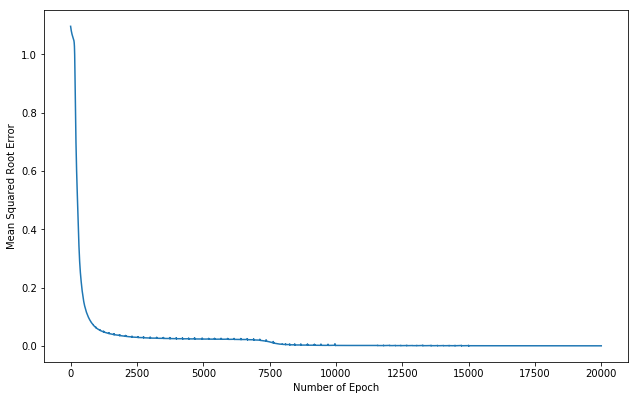

In [198]:
# Instantiate RNN model
model_plant_LSTM = plant_LSTM()
model_plant_LSTM.cuda()
print(model_plant_LSTM)

count,loss_graph = train_plant(model_plant_LSTM,x_train, y_train)

plot_loss(count,loss_graph)

## Test Plant Emulator

In [199]:
#test RNN
def test_plant(model,x_test,y_test):

    criterion = nn.MSELoss()

    hidden=model.init_hidden(data_n[0:test_size,0,:])
    hidden,predict=model(x_test,hidden)
    
    loss_test=criterion(predict,y_test)

    pred=normalizer.de_normalize(predict)
    
    return loss_test,pred

In [200]:
#plotting
def plot_graph(data,pred,state=0,scale=3,ylabel='Pole Angle (deg)',Title='Pole Angle'):
    
    xlabel='Time Step'
    
    width = scale*3.487
    height = width / 1.618

    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    x=np.arange(data_t.size(1)-1)
    
    f= 1
    if Title == 'Pole Angle':
        f = 57.2958
        
    y=data_t[1,1:,state].cpu().numpy()*f
    y2 = pred[1,:,state].detach().cpu().numpy()*f
    
    ax.plot(x, y,'-')
    ax.plot(x, y2,'-')
    
    ax.legend(['Actual','Predicted (RNN)'])
    ax.set_title(Title)

In [201]:
loss_test,pred=test_plant(model_plant_RNN,x_test,y_test)
print(loss_test)

tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward>)


In [202]:
loss_test,pred=test_plant(model_plant_LSTM,x_test,y_test)
print(loss_test)

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward>)


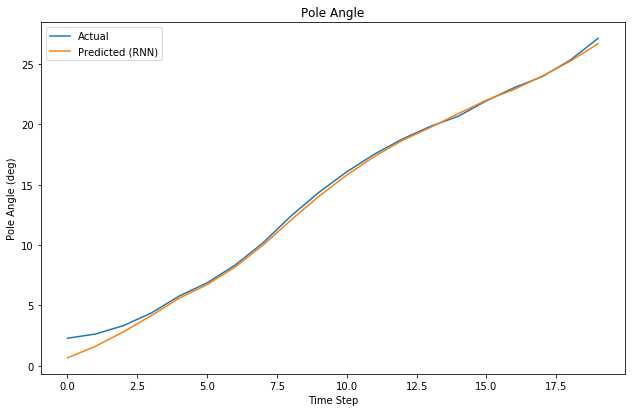

In [203]:
plot_graph(data,pred,state=2)

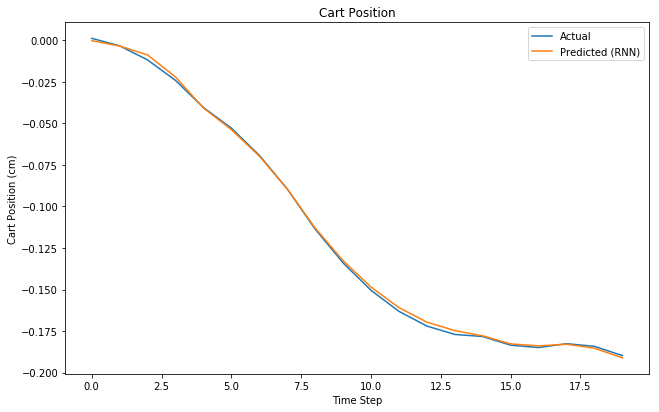

In [204]:
plot_graph(data,pred,state=0,ylabel='Cart Position (cm)',Title='Cart Position')

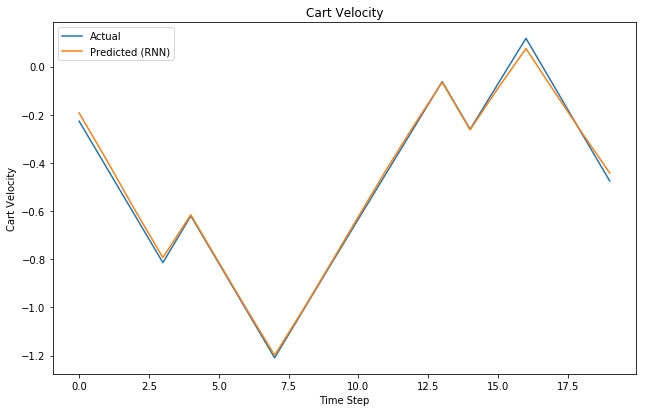

In [205]:
plot_graph(data,pred,state=1,ylabel='Cart Velocity',Title='Cart Velocity')

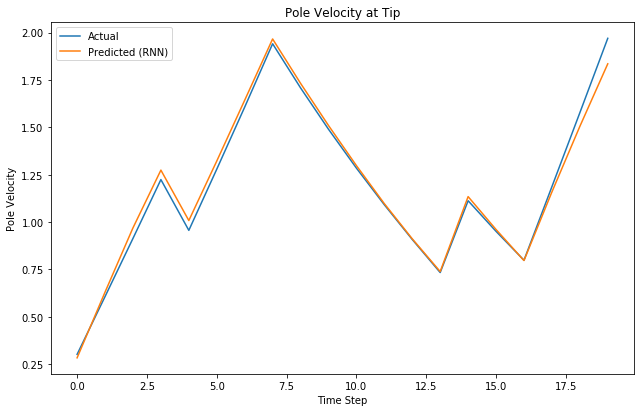

In [206]:
plot_graph(data,pred,state=3,ylabel='Pole Velocity',Title='Pole Velocity at Tip')

## Save model

In [207]:
normalizer_save = open('Models/normalizer', 'wb') 
pickle.dump(normalizer, normalizer_save)

In [208]:
PATH = 'Models/model_plant_RNN'
torch.save(model_plant_RNN.state_dict(), PATH)

In [209]:
PATH = 'Models/model_plant_LSTM'
torch.save(model_plant_LSTM.state_dict(), PATH)